# Semi-Supervised Analysis of Principles of Persuasion Intensity in Phishing Messages

<div style="text-align: center;">
    <img src="resources/banner.png" alt="Descripción" style="width:30%;">
</div>

For a deeper dive into the project and to explore all the details, please visit our [README file](readme.md). You'll find everything you need to know, from the project's background and objectives to the nitty-gritty of how it works.

- Date: 2025.01.05
- Researchers:
	- Dr. Lázaro Bustio-Martínez ([lazaro.bustio@ibero.mx](lazaro.bustio@ibero.mx)).
	- Dr. Vitali Herrera-Semenets ([vherrera@cenatav.co.cu](vherrera@cenatav.co.cu)).
	- Dr. Miguel Á. Álvarez-Carmona ([miguel.alvarez@cimat.mx](miguel.alvarez@cimat.mx)).
	- Dr. Jorge Á. González-Ordiano ([jorge.gonzalez@ibero.mx](jorge.gonzalez@ibero.mx)).
	- Dr. Jan van den Berg
	- Dr. Pedro Á. Santander-Molina
- Contact: [Dr. Lázaro Bustio Martínez](lazaro.bustio@ibero.mx).
- Python version: 3.12.8

Determine the intensity level for each principle of persuasion. This code is developed for Python 3.12.8.

# Defining constant variables

In [2]:
# Principles of Persuasion
# Definition of the persuasion principles used in the analysis
# These principles are based on established psychological theories of influence
POP = "authority"               # Persuasion principle to analyze
POPS = [
	"authority",                            # Authority principle: people tend to follow those they consider experts
	"distraction",                          # Distraction: diverting the audience's attention to influence their decision
	"liking_similarity_deception",          # Liking and similarity: people are more likely to be persuaded by those they like or who are similar to them, even if deception is involved
	"social_proof",                         # Social proof: the influence that others' behavior has on decision-making
	"commitment_integrity_reciprocation"    # Commitment, integrity, and reciprocity: the desire to be consistent with prior commitments and the tendency to return favors
]

# Natural Language Processing Model Configuration
# Specifying the models used for text processing and analysis
TOKENIZER = "distilbert-base-uncased"      # DistilBERT-based tokenizer that converts text into tokens for the model
EMBEDDINGS_MODEL = "distilbert-base-uncased"  # DistilBERT model that generates embeddings for words, useful for NLP tasks

# Clustering Parameters
# Maximum number of clusters to consider when searching for optimal cluster count
MAX_K = 11  # Set to 11 to allow search range from 2 to 10 clusters

# Output Configuration
# Folder path for storing results specific to the persuasion principle being analyzed
PRINCIPLE_FOLDER = ""

# Plot Configuration
# Types of plots to be generated during analysis
PLOT_OBJECTIVES = ("optimum_k", "normal_plot")

# Directory Structure
# Definition of working directories for different aspects of the analysis
RESULT_FOLDER = "results"   # Directory for storing analysis results
DATA_FOLDER = "data"        # Directory for storing input and processed data
MODEL_FOLDER = "models"     # Directory for storing trained models
TEMP_FOLDER = "temp"        # Directory for storing temporary files

# Analysis Thresholds
# Critical values used in the clustering and analysis process
SILHOUETTE_THRESHOLD = 0.20     # Minimum silhouette score threshold for accepting clusters
								# Higher values indicate better-defined clusters

CORRESPONDENCE_THRESHOLD = 0.95 # Similarity threshold for correspondence calculation
								# Represents the minimum percentage of similarity required
								# Higher values indicate stricter matching criteria
								
INSTALL_PACKAGES = False       # Install required packages if not found

SCALE_DATA = True           # Scale data before clustering
#NORMALIZE_DATA = False         # Normalize
#STANDARDIZE_DATA = False       # Standardize
#LOG_TRANSFORM_DATA = False     # Log transform data
#MIN_MAX_SCALE = False          # Min-max scaling

# Setting the working environment

The philosophy followed in this Notebook is that everything needed for its execution will be installed, referenced, and configured within the Notebook itself. In this way, the Notebook can be executed smoothly on any other system

## Defining logging

In [3]:
import logging

# Colores ANSI
class LogColors:
	INFO_BOLD = "\033[1;32m"  # Verde intenso (negrita) para INFO
	INFO = "\033[0;32m"  # Verde suave para INFO (esto lo cambiaré a verde lima)
	WARNING_BOLD = "\033[1;33m"  # Amarillo intenso (negrita) para WARNING
	WARNING = "\033[0;33m"  # Amarillo suave para WARNING
	ERROR_BOLD = "\033[1;31m"  # Rojo intenso (negrita) para ERROR
	ERROR = "\033[0;31m"  # Rojo suave para ERROR
	RESET = "\033[0m"  # Resetear el color

# Formateador personalizado
class ColoredFormatter(logging.Formatter):
	def format(self, record):
		# Colorear el tipo de mensaje (levelname) y el mensaje del log
		if record.levelname == "INFO":
			record.levelname = f"{LogColors.INFO_BOLD}{record.levelname}{LogColors.RESET}"
			record.msg = f"{LogColors.INFO}{record.msg}{LogColors.RESET}"
		elif record.levelname == "WARNING":
			record.levelname = f"{LogColors.WARNING_BOLD}{record.levelname}{LogColors.RESET}"
			record.msg = f"{LogColors.WARNING}{record.msg}{LogColors.RESET}"
		elif record.levelname == "ERROR":
			record.levelname = f"{LogColors.ERROR_BOLD}{record.levelname}{LogColors.RESET}"
			record.msg = f"{LogColors.ERROR}{record.msg}{LogColors.RESET}"
	   
		return super().format(record)

# Configuración del logger
logger = logging.getLogger("MiLogger")
logger.setLevel(logging.INFO)

# Evitar manejadores duplicados
logger.handlers.clear()

# Manejador de consola con colores
console_handler = logging.StreamHandler()
formato = ColoredFormatter("%(asctime)s: %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
console_handler.setFormatter(formato)
logger.addHandler(console_handler)

# Desactivar el logger raíz (limpiar los manejadores raíz)
logging.getLogger().handlers.clear()

# Ejemplo de uso
logger.info("The code has started running correctly.")
logger.warning("This is a warning message.")
logger.error("An error occurred in the code.")

2025-02-26 17:28:02: INFO - The code has started running correctly.
2025-02-26 17:28:02: WARNING - This is a warning message.
2025-02-26 17:28:02: ERROR - An error occurred in the code.


## Installing Libraries

To avoid compatibility issues, this notebook is designed to be self-contained. All necessary libraries are installed and then imported within this cell. Any additional libraries should also be installed here before importing. This ensures the notebook can be run in any environment without requiring external installations.

In [4]:
# Flag to control whether packages should be installed
# Set to True to enable installation, False to skip
install_packages = INSTALL_PACKAGES

if install_packages:
    import subprocess

    logger.info("📦 Installing required libraries...")

    # List of packages to be installed
    # These packages cover various data science and machine learning needs:
    # - Data manipulation: pandas, numpy
    # - Visualization: matplotlib, seaborn, plotly, pandasgui
    # - Machine learning: scikit-learn, torch, transformers
    # - Clustering: hdbscan
    # - System monitoring: psutil, gputil, gputils
    # - UI components: ipywidgets
    # - Data presentation: prettytable
    packages = [
        "ipywidgets",           # Interactive widgets for Jupyter notebooks
        "pandas",               # Data manipulation and analysis
        "numpy",                # Numerical computing
        "matplotlib",           # Basic plotting library
        "seaborn",              # Statistical data visualization
        "scipy",                # Scientific computing
        "scikit-learn",         # Machine learning algorithms
        "transformers",         # NLP transformers library
        "pandasgui",            # GUI for pandas DataFrames
        "torch",                # Deep learning framework
        "psutil",               # System and process utilities
        "gputil",               # GPU monitoring
        "hdbscan",              # Hierarchical density-based clustering
        "prettytable",          # Pretty-print tabular data
        "gputils",              # GPU utilities
        "plotly"                # Interactive plotting library
        #"ensembleclustering"
    ]

    # Install each package using pip in a subprocess
    # Using subprocess prevents installation from blocking the main process
    # and allows for better error handling
    for package in packages:
        logger.info(f"Installing {package}...")
        try:
            # Run pip install command with error checking
            # - stdout and stderr are captured as text
            # - check=True raises CalledProcessError if installation fails
            subprocess.run(["pip", "install", package], 
                         check=True, 
                         stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, 
                         text=True)
            logger.info(f" {package} package installed correctly!")
            INSTALL_PACKAGES = False 
        except subprocess.CalledProcessError as e:
            # Log any installation errors with the error message
            logger.error(f"Error installing {package}: {e.stderr}")

    # Inform user that kernel restart is needed
    # This is necessary for the new packages to be available in the current session
    logger.info("🔄 Installation complete. Please restart the kernel manually from VS Code.")
else:
    # Message when installation is skipped
    logger.info("🚫 Library installation is disabled.")

2025-02-26 17:28:02: INFO - 🚫 Library installation is disabled.


## Imports

After installing the libraries, then they can be imported and used in the code.

In [5]:
# Logger Message
logger.info("Starting the import of necessary libraries for the project...")

# This cell consolidates all necessary imports for the notebook.
# It is organized into sections for standard libraries, third-party libraries,
# scikit-learn, SciPy, Transformers, PandasGUI, and Pandas, with inline comments
# explaining the purpose of each import.

# Standard Library Imports
import os  # For interacting with the operating system (e.g., file paths)
import platform  # To get information about the system
import pickle  # For serializing and de-serializing Python object structures
import json  # For working with JSON data
import re  # For regular expression operations
import warnings  # To manage warnings
from itertools import product  # For creating cartesian products of iterables

# ---
# Third-Party Library Imports
import psutil  # For retrieving information about running processes and system resource utilization
import torch  # A deep learning framework
import hdbscan  # For density-based clustering
import matplotlib.pyplot as plt  # For creating plots and visualizations
import matplotlib.colors as mcolors  # Provides classes defining colors and colormaps
import matplotlib.cm as cm  # Colormap handling
import seaborn as sns  # For statistical data visualization
from prettytable import PrettyTable  # For displaying data in a tabular format

# ---
# Scikit-learn Imports
from sklearn.decomposition import PCA  # For Principal Component Analysis (dimensionality reduction)
from sklearn.cluster import (  # Various clustering algorithms
	AffinityPropagation,
	DBSCAN,
	KMeans,
	MeanShift,
	OPTICS,
	SpectralClustering,
)
from sklearn.metrics import (  # Evaluation metrics for models
	silhouette_score,
	confusion_matrix,
	pairwise_distances,
)
from sklearn.mixture import GaussianMixture  # Gaussian Mixture Model
from sklearn.pipeline import Pipeline  # For building machine learning pipelines
from sklearn.preprocessing import StandardScaler  # For standardizing features

# ---
# SciPy Imports
from scipy.optimize import linear_sum_assignment  # For solving the linear sum assignment problem
from scipy.spatial.distance import cdist  # For calculating distances between points

# ---
# Transformers Imports
from transformers import (  # Importing specific modules from the transformers library
	DistilBertModel,
	DistilBertTokenizer
)

# ---
# PandasGUI Imports
#from pandasgui import show  # For showing Pandas DataFrames in a GUI

# ---
# Pandas Imports
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis

# ---

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding may not work as expected.")
warnings.filterwarnings("ignore", message="All reachability values are inf. Set a larger max_eps or all data will be considered outliers.")
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# Logger Message
logger.info("All libraries were imported successfully.")

2025-02-26 17:28:02: INFO - Starting the import of necessary libraries for the project...
2025-02-26 17:28:10: INFO - All libraries were imported successfully.


## Directory Structure Setup

This code block establishes the essential directory structure for our project, creating all necessary working folders while providing detailed logging of the process.

### Directory Overview

The script creates four main directories:

* **Results Directory (`RESULT_FOLDER`)** : Stores all output files and analysis results generated during the project execution.

* **Data Directory (`DATA_FOLDER`)**:  Contains both raw input data and processed datasets.

* **Models Directory (`MODEL_FOLDER`)**: Dedicated to storing trained models and model-related files.

* **Temporary Directory (`TEMP_FOLDER`)**: Manages intermediate files and temporary data that may be generated during processing.

---
_**Note:** Make sure you have appropriate write permissions in your working directory before running this code._

---

In [6]:
logger.info("Creating folders for the project...")

try:
	# Create Results Directory
	# This folder stores the output and analysis results
	logger.info(f"Creating folder {RESULT_FOLDER}...")
	if not os.path.exists(RESULT_FOLDER):
		os.makedirs(RESULT_FOLDER)
		logger.info(f"Folder {RESULT_FOLDER} created successfully.")
	else:
		logger.info(f"Folder {RESULT_FOLDER} already exists.")
	
	# Create Data Directory
	# This folder stores input data and processed datasets
	logger.info(f"Creating folder {DATA_FOLDER}...")
	if not os.path.exists(DATA_FOLDER):
		os.makedirs(DATA_FOLDER)
		logger.info(f"Folder {DATA_FOLDER} created successfully.")
	else:
		logger.info(f"Folder {DATA_FOLDER} already exists.")
	
	# Create Models Directory
	# This folder stores trained models and model-related files
	logger.info(f"Creating folder {MODEL_FOLDER}...")
	if not os.path.exists(MODEL_FOLDER):
		os.makedirs(MODEL_FOLDER)
		logger.info(f"Folder {MODEL_FOLDER} created successfully.")
	else:
		logger.info(f"Folder {MODEL_FOLDER} already exists.")
	
	# Create Temporary Directory
	# This folder stores intermediate files and temporary data
	logger.info(f"Creating folder {TEMP_FOLDER}...")
	if not os.path.exists(TEMP_FOLDER):
		os.makedirs(TEMP_FOLDER)
		logger.info(f"Folder {TEMP_FOLDER} created successfully.")
	else:
		logger.info(f"Folder {TEMP_FOLDER} already exists.")
		
	logger.info("Folders created successfully.")

except Exception as e:
	# Log any errors that occur during folder creation
	logger.error(f"Error creating folders: {e}")

2025-02-26 17:28:10: INFO - Creating folders for the project...
2025-02-26 17:28:10: INFO - Creating folder results...
2025-02-26 17:28:10: INFO - Folder results already exists.
2025-02-26 17:28:10: INFO - Creating folder data...
2025-02-26 17:28:10: INFO - Folder data already exists.
2025-02-26 17:28:10: INFO - Creating folder models...
2025-02-26 17:28:10: INFO - Folder models already exists.
2025-02-26 17:28:10: INFO - Creating folder temp...
2025-02-26 17:28:10: INFO - Folder temp already exists.
2025-02-26 17:28:10: INFO - Folders created successfully.


## Saving configurations of the VENV

To further ensure compatibility, generate a requirements file listing the project's dependencies and save it as `requirements.txt`.

In [7]:
if (INSTALL_PACKAGES == True):
	# Generate a 'requirements.txt' file containing all installed Python packages.
	%pip freeze > requirements.txt  # This command lists all installed packages and writes them to 'requirements.txt'.

	# Log a message indicating that the file has been successfully created.
	logger.info("'requirements.txt' file has been generated successfully!")

# Utils functions

This section contains commonly used utility functions that provide reusable support throughout the codebase.

**`plot_line_chart`**: Plots a line chart based on the provided x and y values, with optional highlighting of an optimal point.

In [8]:
def plot_line_chart(x_values, y_values, title, x_label, y_label, file_path, plot_objective=None, highlight_value=None, note=None):
	"""
	Plots a line chart based on the provided x and y values, with optional highlighting of an optimal point.

	Parameters:
		x_values (list or tuple): X-axis values.
		y_values (list or tuple): Y-axis values.
		title (str): Chart title.
		x_label (str): Label for the X-axis.
		y_label (str): Label for the Y-axis.
		file_path (str): Path to save the chart as a PNG file.
		plot_objective (str, optional): Specifies if a special objective should be highlighted (e.g., "optimum_k").
		highlight_value (float, optional): The X-axis value to be highlighted with a vertical line.
		note (str, optional): Additional text to be displayed on the chart.

	Raises:
		ValueError: If input types are incorrect or required values are missing.
	"""

	# Input validations
	if not isinstance(x_values, (list, tuple)) or not isinstance(y_values, (list, tuple)):
		raise ValueError("x_values and y_values must be lists or tuples.")

	if len(x_values) != len(y_values):
		raise ValueError("x_values and y_values must have the same length.")

	if not isinstance(title, str) or not isinstance(x_label, str) or not isinstance(y_label, str):
		raise ValueError("Title, x_label, and y_label must be strings.")

	if plot_objective == "optimum_k" and highlight_value is None:
		raise ValueError("highlight_value must be provided when plot_objective is 'optimum_k'.")

	# Create the figure for the plot
	plt.figure(figsize=(8, 5))

	# Draw the line plot
	plt.plot(x_values, y_values, 'bo-', label='Data')

	# If 'optimum_k' is specified, add a vertical line at the highlight value
	if plot_objective == "optimum_k" and highlight_value is not None:
		plt.axvline(x=highlight_value, color='red', linestyle='--', label=f"Optimal k = {highlight_value}")

	# Add title and axis labels
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)

	# Display a note on the plot if provided
	if note:
		plt.text(0.5, 0.95, note, horizontalalignment='center', verticalalignment='top', 
				 transform=plt.gca().transAxes, fontsize=10, color='black', 
				 bbox=dict(facecolor='white', alpha=0.5))

	# Add legend
	plt.legend()

	# Save the plot to the specified file path if provided
	if file_path is not None:
		plt.savefig(file_path, format='png')
		logger.info(f"Chart saved at: '{file_path}'")

	# Show the plot
	plt.show()
	plt.close()

The ``plot_point_chart`` function generates a scatter plot to visualize data points grouped by clusters. It allows for highlighting a specific value on the X-axis, making it useful for identifying optimal cluster numbers or key data points. Additionally, it supports adding annotations and saving the plot as an image file.

In [9]:
def plot_point_chart(x_values, y_values, clusters, title, x_label, y_label, file_path=None, plot_objective=None, highlight_value=None, note=None):
	"""
	Plots a scatter plot of data points, categorized by clusters, with optional highlighting of an optimal point.

	Parameters:
		x_values (list or tuple): X-axis values.
		y_values (list or tuple): Y-axis values.
		clusters (list or tuple): Cluster labels for each data point.
		title (str): Chart title.
		x_label (str): Label for the X-axis.
		y_label (str): Label for the Y-axis.
		file_path (str, optional): Path to save the chart as a PNG file.
		plot_objective (str, optional): Specifies if a special objective should be highlighted (e.g., "optimum_k").
		highlight_value (float, optional): The X-axis value to be highlighted with a vertical line.
		note (str, optional): Additional text to be displayed on the chart.

	Raises:
		ValueError: If input types are incorrect or required values are missing.
	"""

	# Input validations
	if not isinstance(x_values, (list, tuple)) or not isinstance(y_values, (list, tuple)):
		raise ValueError("x_values and y_values must be lists or tuples.")

	if len(x_values) != len(y_values):
		raise ValueError("x_values and y_values must have the same length.")

	if not isinstance(title, str) or not isinstance(x_label, str) or not isinstance(y_label, str):
		raise ValueError("Title, x_label, and y_label must be strings.")

	if plot_objective == "optimum_k" and highlight_value is None:
		raise ValueError("highlight_value must be provided when plot_objective is 'optimum_k'.")

	# Create a DataFrame to associate clusters with data points
	plot_df = pd.DataFrame({
		'x': x_values,
		'y': y_values,
		'Cluster': clusters
	})

	# Create the scatter plot
	plt.figure(figsize=(8, 6))
	sns.scatterplot(data=plot_df, x='x', y='y', hue='Cluster', palette='Set1', marker='o', s=100)

	# Add title and axis labels
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.legend(title="Clusters", loc='best')

	# If 'optimum_k' is specified, add a vertical line at the highlight value
	if plot_objective == "optimum_k" and highlight_value is not None:
		plt.axvline(x=highlight_value, color='red', linestyle='--', label=f"Optimal k = {highlight_value}")

	# Display a note on the plot if provided
	if note:
		plt.figtext(0.99, 0.01, note, horizontalalignment='right', fontsize=12, color='black', 
					ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, 
					edgecolor='black', boxstyle='round,pad=1'))

	# Save the plot if a file path is provided
	if file_path:
		plt.savefig(file_path, format='png')
		logger.info(f"Chart saved at: '{file_path}'")

	# Show the plot
	plt.show()
	plt.close()


The ``get_system_info`` function collects and returns detailed system information, including CPU, RAM, and GPU specifications. It retrieves data such as the Python version, operating system, processor architecture, and available memory. Additionally, it detects and reports GPU details using both GPUtil and PyTorch, making it useful for assessing hardware capabilities before running computationally intensive tasks. The function returns this information in a structured DataFrame for easy readability and analysis.

In [10]:
def get_system_info():
	"""
	Retrieves system information, including CPU, RAM, GPU, and NPU details.

	Returns:
		pd.DataFrame: A DataFrame containing system specifications such as 
					  Python version, processor details, memory capacity, and GPU stats.

	Dependencies:
		- platform: To retrieve OS and processor details.
		- psutil: To get CPU count and RAM details.
		- GPUtil: To fetch GPU-related information (if available).
		- torch: To check CUDA-compatible GPUs (if available).
		- pandas: To format the data into a structured DataFrame.
	"""

	# Initialize a dictionary to store system information
	system_info = {
		"Info": ["Python version", "Platform", "Processor", "Architecture", "Number of CPUs", "Total RAM"],
		"Details": [
			platform.python_version(),
			f"{platform.system()} {platform.release()}",
			platform.processor(),
			platform.architecture()[0],
			psutil.cpu_count(logical=True),
			f"{psutil.virtual_memory().total / (1024 ** 3):.2f} GB"
		]
	}

	# Retrieve GPU details using GPUtil
	#gpus = GPUtil.getGPUs()
	#if gpus:
	#	for gpu in gpus:
	#		system_info["Info"].append(f"GPU: {gpu.name}")
	#		system_info["Details"].append(f"Memory Total: {gpu.memoryTotal} MB")
	#		system_info["Info"].append("GPU Memory Free")
	#		system_info["Details"].append(f"{gpu.memoryFree} MB")
	#		system_info["Info"].append("GPU Memory Used")
	#		system_info["Details"].append(f"{gpu.memoryUsed} MB")
	#		system_info["Info"].append("GPU Utilization")
	#		system_info["Details"].append(f"{gpu.load * 100:.2f}%")
	#else:
	#	# If no GPU is detected, add a placeholder entry
	#	system_info["Info"].append("GPU")
	#	system_info["Details"].append("No GPU detected with GPUtil.")

	# Retrieve GPU details using PyTorch (alternative method)
	if torch.cuda.is_available():
		gpu_count = torch.cuda.device_count()
		for i in range(gpu_count):
			system_info["Info"].append(f"CUDA GPU {i}: {torch.cuda.get_device_name(i)}")
			system_info["Details"].append(f"GPU Capability: {torch.cuda.get_device_capability(i)}")
			system_info["Info"].append("Total Memory")
			system_info["Details"].append(f"{torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB")
	else:
		# If no CUDA-compatible GPU is found, add a placeholder entry
		system_info["Info"].append("CUDA GPU")
		system_info["Details"].append("No GPU detected with PyTorch.")

	# Convert the collected data into a pandas DataFrame for better readability
	return pd.DataFrame(system_info)


## Checking hardware resources

Displays system hardware and software specifications in a structured and readable format. It helps users quickly assess the system's capabilities, including CPU, RAM, and GPU details, which is particularly useful for performance analysis, debugging, and ensuring compatibility with resource-intensive applications.

In [11]:
# Retrieve system information using the get_system_info function
system_df = get_system_info()

# Create a PrettyTable instance for formatted output
system_table = PrettyTable()
system_table.field_names = ["Info", "Details"]

# Populate the table with system information from the DataFrame
for index, row in system_df.iterrows():
	system_table.add_row([row['Info'], row['Details']])

# Display the system information in a readable table format
print("\nSystem information:")
print(system_table)


System information:
+----------------+-----------------------------------------------------+
|      Info      |                       Details                       |
+----------------+-----------------------------------------------------+
| Python version |                        3.12.9                       |
|    Platform    |                      Windows 11                     |
|   Processor    | Intel64 Family 6 Model 186 Stepping 2, GenuineIntel |
|  Architecture  |                        64bit                        |
| Number of CPUs |                          16                         |
|   Total RAM    |                       15.73 GB                      |
|    CUDA GPU    |            No GPU detected with PyTorch.            |
+----------------+-----------------------------------------------------+


# Data gathering and filtering

The phishing messages and persuasion principles are stored in the file ``data\pop_dataset_Full(Tiltan).csv``, which needs to be loaded for further analysis. So, it is needed to load and preprocess a dataset containing phishing messages. It validates the existence of necessary files and folders, checks for expected columns, and filters the data to focus only on phishing emails (``class == 1``). The filtered data is then prepared for further analysis, ensuring that only relevant information is retained. This process is essential for tasks such as phishing detection or training machine learning models for cybersecurity.

In [12]:
# File name for the dataset
file_name = "pop_dataset_Full(Tiltan).csv"

# Validate if the data folder exists
if os.path.exists(DATA_FOLDER):
	# Construct the full path to the file
	path = os.path.join(DATA_FOLDER, file_name)
	
	# Validate if the CSV file exists at the given path
	if os.path.exists(path):
		logger.info(f"Starting data processing by reading the file located at '{path}'...")

		try:
			# Load the CSV file into a pandas DataFrame, using the second row as the header
			data_df = pd.read_csv(path, header=1)
			logger.info("Data loaded successfully.")
		except Exception as e:
			# Log an error if the CSV file reading fails
			logger.error(f"Error reading the CSV file: {e}")
			raise

		# List of expected columns in the dataset, including columns related to phishing data
		expected_columns = ["id", "path", "hash", "subject", "txt"] + POPS + ["class", "label"]
		
		# Check for missing columns in the loaded dataset
		missing_columns = [col for col in expected_columns if col not in data_df.columns]
		
		# If there are missing columns, log an error and raise an exception
		if missing_columns:
			logger.error(f"The following expected columns are missing from the data: {missing_columns}")
			raise ValueError(f"Missing columns: {missing_columns}")

		# Filter the dataset to keep only the phishing emails (where 'class' column is 1)
		data_phish = data_df[data_df["class"] == 1]
		
		# Check if there is any phishing data in the filtered DataFrame
		if data_phish.empty:
			logger.warning("No phishing data found in the dataset.")
		
		# Select the necessary columns for further processing
		data = data_phish[expected_columns]
	else:
		# Log an error if the CSV file is not found in the expected location
		logger.error(f"The file '{file_name}' does not exist in the folder '{DATA_FOLDER}'. Please check the file name and location.")
else:
	# Log an error if the data folder does not exist
	logger.error(f"The data folder '{DATA_FOLDER}' does not exist. Please create it and place the data file in it.")

# Display the data (for verification)
data

2025-02-26 17:28:11: INFO - Starting data processing by reading the file located at 'data\pop_dataset_Full(Tiltan).csv'...
2025-02-26 17:28:11: INFO - Data loaded successfully.


,id,path,hash,subject,txt,authority,distraction,liking_similarity_deception,social_proof,commitment_integrity_reciprocation,class,label
1087,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,52f8f694517011d944083f22ace9448e,Urgent Fraud Prevention Group Notice,Urgent Fraud Prevention Group Notice You have...,1,1,0,0,0,1,Phish
1088,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,b4dab37a7c9be664f7bbd4a5f48e9409,your paypal account user domain,Dear PayPal Inc. account holder PayPal is cons...,1,0,0,0,1,1,Phish
1089,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,c5a00795f1af36457fa3e6da1ce902ce,Notification Update Your eBay Profile,Dear eBay Customer As the domain.com and infor...,1,0,0,0,1,1,Phish
1090,9765,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,5d668953b7cf30441baffbb296702768,Thanks again for using online payments,E mail Security Information. Dear Customer Tha...,0,0,0,0,0,1,Phish
1091,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0009311d8938d26b6807618aa3febc78,PayPal Flagged Account,Dear PayPal Member Your account has been rando...,1,0,0,0,1,1,Phish
...,...,...,...,...,...,...,...,...,...,...,...,...
2088,5693,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,ce0d77e4c83d7499067766195159a562,This e mail is to notify you the staff and,This e mail is to notify you the staff and stu...,1,0,0,0,0,1,Phish
2089,5694,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,388372d4dac30e997fd3fa3921577c26,Security Warning for user domain Click here to...,Security Warning for user domain Click here to...,0,0,0,0,1,1,Phish
2090,5697,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,d2b71708bc1e7398e0046425f93e8f8d,A Computer Database Maintenance is currently g...,A Computer Database Maintenance is currently g...,1,0,0,1,0,1,Phish
2091,5698,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,9e9f2f57a81fb6f80a7201cc1c0523a0,To Department Chairs and Unit Leaders Please d...,To Department Chairs and Unit Leaders Please d...,0,0,0,0,0,1,Phish


# Data representation

Messages are stored as text, but they need to be represented in a way that facilitates processing. The data representation method that works best for phishing detection is BERT. BERT (Bidirectional Encoder Representations from Transformers) has the ability to understand the context of words in both directions, enabling better interpretation and analysis of the text. Additionally, BERT has proven highly effective in text classification tasks and detecting anomalous patterns—essential characteristics for identifying phishing messages. Leveraging these capabilities, BERT can more accurately detect malicious messages and protect users against phishing attacks.

To implement this, DistilBERT is employed. DistilBERT uses a tokenizer that converts the input text into tokens that the model can process. This model is a smaller, faster, and lighter version of BERT, designed to deliver high performance while requiring fewer computational resources. An informational log entry is added to indicate that both the DistilBERT tokenizer and model have been loaded successfully. By utilizing DistilBERT, which retains 97% of BERT's language understanding capabilities while being more efficient, the system enhances its ability to detect phishing attempts in a streamlined and resource-effective manner.

---
_**Note:** Other data repesentations can, and in matter of fact, **must be** tested. Following DistlBERT, GloVe will be also tested._

---

The tokenizer and ``DistilBERT`` model are loaded to transform text data into meaningful embeddings for natural language processing tasks. ``DistilBERT``, a smaller version of ``BERT``, is used for tasks like text classification or feature extraction. The tokenizer processes the text into tokens, which the model then uses to generate embeddings. This step is essential for preparing the model to work with textual data, ensuring that the text is in the appropriate format for further analysis or predictions.

In [13]:
# Load the tokenizer and base model of DistilBERT
try:
	# Load the tokenizer from the pre-trained model specified by the TOKENIZER variable
	tokenizer = DistilBertTokenizer.from_pretrained(TOKENIZER)
	
	# Load the base DistilBERT model for embeddings from the specified EMBEDDINGS_MODEL
	model = DistilBertModel.from_pretrained(EMBEDDINGS_MODEL)  # Base model
	
	# Log success message when both the tokenizer and model are successfully loaded
	logger.info(f"Tokenizer '{TOKENIZER}' and model '{EMBEDDINGS_MODEL}' have been downloaded/loaded successfully!")
	
except Exception as e:
	# Log an error message if there is any issue in downloading or loading the tokenizer and model
	logger.error(f"Error downloading/loading '{TOKENIZER}' tokenizer and model: {e}")


2025-02-26 17:28:12: INFO - Tokenizer 'distilbert-base-uncased' and model 'distilbert-base-uncased' have been downloaded/loaded successfully!


It is needed to define a function that processes a list of texts to generate their embeddings using a pre-trained model. This function processes a list of texts to generate their embeddings using a pre-trained model. The texts are first tokenized with the tokenizer, ensuring that they are properly padded and truncated to fit the model's input requirements. Then, the tokenized texts are passed through the model to generate embeddings. The embeddings are averaged across the token dimensions (word embeddings) to create a single embedding per text. This is useful for transforming text into a numerical format that can be used in machine learning or natural language processing tasks such as classification, clustering, or similarity measurement.

In [14]:
# Function to obtain embeddings from text
def get_embeddings(texts):
	# Log that the embedding process is starting
	logger.info("Starting to process texts for embeddings...")
	
	# Tokenize the input texts using the pre-trained tokenizer, and ensure padding, truncation, and a max length of 512 tokens
	inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
	
	# Log the number of texts tokenized
	logger.info(f"Tokenized {len(texts)} texts.")
	
	# Disable gradient calculation as we are not training the model
	with torch.no_grad():
		# Log the start of embedding generation
		logger.info("Generating embeddings...")
		
		# Generate embeddings by passing the tokenized inputs through the model
		outputs = model(**inputs)
	
	# Use the mean of the word embeddings (from the last hidden state) to obtain a single embedding per text
	embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
	
	# Log the shape of the generated embeddings
	logger.info(f"Generated embeddings with shape: {embeddings.shape}")
	
	# Return the embeddings as a numpy array
	return embeddings


It is needed to filter messages according to different principles of persuasion and to calculate their vector representations, known as **embeddings**. To do so, the corresponding embedding representation is calculated for each principle of persuasion.

---
_**Note:** It is very complicated, in terms of the necessary data structures, to automatically analyze all the principles of persuasion in a single piece of code. Therefore, to address this situation, one principle of persuasion will be analyzed at a time. The variable `pop` will contain the principle of persuasion to be analyzed, and it will be checked that pop is in the list of persuasion principles in the data to avoid errors later on._

---

In [15]:
# The principle folder is set to the value of 'pop', representing the current principle of interest. This can be changed in the CONSTANT DEFINITION cell.
PRINCIPLE_FOLDER = POP

# Check if the selected principle is valid (i.e., if it exists in the list of predefined principles)
if (POP not in POPS):
	# Log an error if the selected principle is not valid
	logger.error(f"Error: '{POP}' is not a valid principle of persuasion.")
else:
	# Log an info message confirming the selected principle and continuing with the analysis
	logger.info(f"'{POP}' has been established as the principle of persuasion of interest at this time. Continuing with the analysis...")


2025-02-26 17:28:13: INFO - 'authority' has been established as the principle of persuasion of interest at this time. Continuing with the analysis...


Here, the phishing messages are filtered to include only those that correspond to the principle of persuasion specified in the `POP` variable. Subsequently, the selected messages are transformed using the chosen data representation method. 

In [16]:
# It is necessary to check if the embeddings representation for the selected principle of persuasion exists in its corresponding folder in the 'results' directory.
# If it doesn't exist, embeddings need to be generated.

embedding_found = False

# Construct the file name based on the selected principle of persuasion (pop)
file_name = f"embeddings_{POP}.csv"

# Filter rows where the selected principle ('pop') has a value of 1 (indicating relevance for the analysis)
filtered_df = data.loc[data[POP] == 1, ['id', 'path', 'hash', 'subject', 'txt']]

# Check if the embeddings file for the selected principle already exists
if os.path.isfile(os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER, file_name)):
	# If the embeddings exist, log a message and set the flag to True
	logger.info(f"Embeddings for '{POP}' already exist. Loading the embeddings...")
	embedding_found = True
	
	try:
		# Attempt to load the existing embeddings from the CSV file
		embed_df = pd.read_csv(os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER, file_name))
		logger.info(f"Embeddings loaded successfully for '{POP}'.")
		
		# Rename columns to 'col_#' format
		embed_df.columns = [
            f"col_{i}" if col.startswith("col_") else col for i, col in enumerate(embed_df.columns)
        ]
		
	except Exception as e:
		# Log an error if there is an issue loading the embeddings
		logger.error(f"Error loading embeddings for '{POP}': {e}")
else:
	# If the embeddings file does not exist, log the creation of embeddings
	logger.info(f"Creating embeddings with '{EMBEDDINGS_MODEL}' representation for '{POP}'...")
	
	# Generate embeddings for the filtered texts using the previously defined function
	embed = get_embeddings(filtered_df["txt"].tolist())

	# Convert the generated embeddings into a DataFrame
	embed_df = pd.DataFrame(embed)
	
	# Rename columns to 'col_#' format
	embed_df.columns = [f"col_{i}" for i in range(embed_df.shape[1])]
	
	# Add "id" and "path" columns to the embeddings dataframe for identification purposes during clustering
	embed_df["id"] = filtered_df["id"].values
	embed_df["path"] = filtered_df["path"].values

# Display the resulting embeddings DataFrame
embed_df

2025-02-26 17:28:13: INFO - Embeddings for 'authority' already exist. Loading the embeddings...
2025-02-26 17:28:13: INFO - Embeddings loaded successfully for 'authority'.


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_760,col_761,col_762,col_763,col_764,col_765,col_766,col_767,id,path
0,0.096209,0.152683,0.193249,0.016189,0.375132,-0.261907,0.125467,0.432013,-0.001726,-0.183225,...,0.155682,-0.306354,-0.080521,-0.177477,0.060439,-0.067538,-0.099230,0.109578,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
1,-0.072205,0.067802,0.357244,0.037719,0.436252,-0.128882,0.049326,0.316047,-0.004852,-0.207884,...,0.170035,-0.258228,-0.156399,-0.067954,-0.057610,-0.112407,-0.168488,0.082323,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
2,0.065490,0.073135,0.303711,-0.038981,0.392661,-0.142789,0.082904,0.269112,0.076318,-0.158853,...,0.119092,-0.134415,-0.093278,-0.098334,0.042149,-0.130044,-0.097641,0.036647,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
3,0.126272,0.011344,0.367267,0.083592,0.449823,-0.145410,0.080765,0.221521,0.057800,-0.145011,...,0.005316,-0.198921,-0.065224,0.068022,-0.140596,-0.091489,-0.092740,0.164466,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
4,0.184803,-0.030021,0.378522,0.010510,0.349926,-0.026439,0.058939,0.317805,0.040234,-0.133832,...,0.027804,-0.183020,0.023366,0.049959,-0.101701,-0.050186,-0.116499,0.137569,9767,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.150477,0.185594,0.334257,-0.059043,0.180246,-0.075516,0.097333,0.352394,0.109118,-0.154295,...,0.087740,-0.225297,0.070205,-0.127896,-0.144014,0.096931,-0.088158,0.113249,5690,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
594,0.234969,-0.043283,0.306206,0.148112,0.331764,-0.168138,0.072470,0.326924,0.058873,-0.193668,...,0.004664,-0.124429,0.155290,0.115657,-0.124182,0.032871,-0.129683,0.066232,5691,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
595,0.105826,0.124749,0.355753,0.108981,0.347318,-0.225326,0.203359,0.278280,0.142702,-0.296989,...,0.068012,-0.220056,-0.091292,0.096117,-0.021350,-0.024908,-0.102940,0.102136,5693,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...
596,0.052480,0.092560,0.231235,-0.095931,0.295719,-0.077306,0.086920,0.346897,0.087620,0.006324,...,0.134313,-0.242091,-0.044011,-0.053774,0.101083,-0.054767,-0.137243,0.216108,5697,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...


Once the data for the selected principle of persuasion has been processed and its corresponding embeddings generated, the results are saved as a CSV file. This ensures that the data is stored in a standardized, easily accessible format for future use. If the embeddings have already been calculated and are available, this step is skipped to avoid redundant processing.

In [17]:
# If embeddings were not found (i.e., they need to be created), proceed to save the generated embeddings
if (embedding_found == False):
	try:
		# Create the full path for the directory where the embeddings will be saved
		path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
		
		# Check if the folder exists; if it doesn't, create it
		if not os.path.exists(path):
			os.makedirs(path)  # This will create all the necessary directories

		# Create the file name for the embeddings CSV
		file_name = f"embeddings_{POP}.csv"
		file_path = os.path.join(path, file_name)
		
		# Save the embeddings DataFrame as a CSV file
		embed_df.to_csv(file_path, index=False, sep=",", decimal=".")
		logger.info(f"Embeddings for '{POP}' have been saved to '{file_path}' successfully!")

	except Exception as e:
		# Log an error message if something goes wrong during the saving process
		logger.error(f"Error saving embeddings for '{POP}' to '{file_path}': {e}")
else:
	# If the embeddings already exist, log a warning message
	logger.warning(f"Embeddings for '{POP}' have already been calculated and stored.")


2025-02-26 17:28:13: WARNING - Embeddings for 'authority' have already been calculated and stored.


# Clustering

The central premise of this research is that _messages of similar intensity related to a specific principle of persuasion should naturally be grouped together_. Therefore, it is crucial to evaluate and compare different clustering algorithms to determine which one produces the most coherent and consistent groupings. The research aims to verify whether the resulting clusters genuinely contain messages with comparable intensities for each principle of persuasion. This approach not only contributes to a deeper understanding of how message intensity is distributed but also ensures that the selected clustering algorithms accurately capture the inherent similarities among the messages.

To achieve this objective, a comprehensive pipeline will be implemented that tests various clustering algorithms, including ``k-Means``, ``DBSCAN``, ``OPTICS``, and ``Gaussian Mixture Models`` (GMM) among others, while remaining open to exploring other algorithms as necessary. For algorithms that require the specification of the number of groups (such as ``k-Means`` and ``GMM``), an analytical approach will be used to determine the optimal number of clusters. The quality of each clustering solution will be rigorously evaluated, and the messages within each group will be carefully analyzed to test the hypothesis that messages with similar intensities for a given principle of persuasion are effectively grouped together. This research aims to refine clustering techniques and validate their ability to represent the underlying structure of persuasion principles in message intensity, ultimately providing insights into the mechanics of persuasive communication.

## Defining and setting the configurations for the clustering algorithms selected

An array is defined to store the clustering algorithms (`clustering_algorithms`) and their respective configurations that will be used.

The `clustering_algorithms` dictionary is a structured configuration for testing and tuning various clustering algorithms. Each key in the dictionary corresponds to a clustering algorithm's name, and its value is another dictionary containing the following attributes:

- **`optimum_k`**: A boolean indicating whether the algorithm supports finding the optimal number of clusters (e.g., `True` for algorithms like KMeans and GaussianMixture that can compute metrics like Silhouette Score for different numbers of clusters).
- **`class`**: The actual class of the clustering algorithm (e.g., `KMeans`, `GaussianMixture`, or `DBSCAN`).
- **`params`**: A dictionary defining the hyperparameters to be tested for the specific algorithm. For example:
	- `n_clusters` or `n_components` are ranges of values for determining the number of clusters in ``KMeans`` or GaussianMixture, respectively.
	- Algorithms like `DBSCAN` and `OPTICS` specify parameters like `eps` (radius) and `min_samples` (minimum points in a cluster).
	- Algorithms that do not rely on a predefined number of clusters, like `HDBSCAN` or `MeanShift`, have `params` suited to their clustering strategies.

This structure allows flexible experimentation with different clustering algorithms and their hyperparameters, while enabling automated selection of the optimal number of clusters for applicable methods.

### Clustering algorithms for detecting intensities in principles of persuasion in phishing messages

| **Algorithm**          | **Strengths**                                                                 | **Convenience for Detecting Persuasion Principles in Phishing Messages**                                                                                                                                                         |
|------------------------|-------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **``KMeans``**             | Efficient, easy to implement, and works well with spherical clusters.         | KMeans is effective when the persuasion principles in phishing messages are distinct and well-separated, making it suitable for relatively simple clustering tasks where the clusters are expected to be clearly defined.                                                                                     |
| **``GaussianMixture``**    | Flexible, handles clusters of different shapes and densities.                | Gaussian Mixture Models are valuable for modeling complex, overlapping persuasion principles in phishing messages. They can capture subtle variations in message intensity and handle mixed principles within a single message.                                                                                                    |
| **``SpectralClustering``** | Handles non-convex clusters, uses graph-based methods for clustering.        | Spectral Clustering is suitable for identifying hidden relationships between messages that may have irregularly shaped or interconnected persuasion principles. It is helpful for discovering complex patterns that may not be captured by other clustering algorithms.                                                                                             |
| **``DBSCAN``**             | Density-based, groups points in high-density regions, marks outliers.        | DBSCAN excels in detecting dense areas of persuasion within phishing messages. Since it does not require the number of clusters to be specified, it is adaptable to unexpected patterns and can uncover areas where persuasion principles are concentrated.                                                             |
| **``OPTICS``**             | Handles varying densities, produces a reachability plot.                      | OPTICS is well-suited for detecting density-based clusters with varying strengths in phishing messages. It captures persuasion principles that may differ in intensity across different messages, helping to model fluctuating persuasive tactics.                                                           |
| **``HDBSCAN``**            | Hierarchical, density-based, robust to noise, determines the number of clusters automatically. | HDBSCAN is effective for identifying clusters where persuasion principles vary in intensity. Its automatic determination of the number of clusters, combined with its robustness to noise, makes it ideal for irregular clustering patterns often found in phishing messages.                                                                          |
| **``MeanShift``**          | Non-parametric, finds dense areas without predefined clusters.               | MeanShift is useful when the number of persuasion principle clusters is unknown. It can identify regions of high density in phishing messages, allowing for the discovery of unexpected patterns related to persuasive strategies.                                                                            |
| **``AffinityPropagation``**| Message-passing, identifies exemplars, automatically determines the number of clusters. | Affinity Propagation is useful for detecting key persuasive messages that represent specific principles. It does not require predefined cluster counts, making it flexible for discovering varied and sometimes unexpected persuasion strategies in phishing messages.                         |

Each algorithm in the table offers unique advantages for clustering phishing messages based on persuasion principles, depending on the data's `characteristics`. KMeans and GaussianMixture work well when persuasion principles are clearly separated or overlapping, respectively. Density-based methods like ``DBSCAN``, ``OPTICS``, and ``HDBSCAN`` are flexible, handling varying densities and not requiring a predefined number of clusters. ``SpectralClustering`` and ``AffinityPropagation`` provide additional flexibility by identifying hidden relationships and exemplar-based clusters, respectively.

The goal is to identify the most effective algorithm to capture the various patterns and intensities of persuasion tactics in phishing attempts.

First, the maximum range for the optimal number of clusters, defined by `MAX_K`, is verified.

In [18]:
logger.info(f"Maximum 'K' value for the search: {MAX_K}")

2025-02-26 17:28:13: INFO - Maximum 'K' value for the search: 11


Defining the clustering algorithms to use and their parameters. ``clustering_algorithms`` dictionary stores the configurations for various clustering algorithms. Each algorithm has a specific class, a flag (optimum_k) that determines whether the optimal number of clusters should be determined, and a set of parameters for tuning the algorithm. ``KMeans``, ``GaussianMixture``, and ``SpectralClustering`` are algorithms that require specifying the number of clusters (``optimum_k=True``), so we define a range of values (``range(2, MAX_K)``) to explore. ``DBSCAN``, ``OPTICS``, ``HDBSCAN``, ``MeanShift``, and ``AffinityPropagation`` do not require specifying the number of clusters (``optimum_k=False``), and their parameters control various aspects of how clusters are formed. Each algorithm has different parameters that define how clusters should be detected or modeled. For example, ``eps`` and ``min_samples`` are used for density-based algorithms like ``DBSCAN``, and ``min_cluster_size`` is used for ``HDBSCAN`` to control the size of clusters. 

This ``clustering_algorithms`` dictionary helps to organize the parameters and settings for the various clustering methods in a clean and easily adjustable way, enabling easy experimentation with different clustering algorithms.

In [19]:
# Dictionary containing different clustering algorithms and their configurations
clustering_algorithms = {
	# KMeans Clustering
	'KMeans': {
		# 'optimum_k' indicates whether the algorithm requires searching for the optimal number of clusters
		'optimum_k': True,
		# The class of the algorithm to be used
		'class': KMeans,
		# Parameters to test for the optimal number of clusters (ranging from 2 to MAX_K)
		'params': {'n_clusters': range(2, MAX_K)}  # Values for searching optimal clusters
	},
	
	# GaussianMixture Clustering
	'GaussianMixture': {
		# 'optimum_k' is True, meaning the number of components should be optimized
		'optimum_k': True,
		# The class of the algorithm to be used
		'class': GaussianMixture,
		# Parameters for the number of components to test (from 2 to MAX_K)
		'params': {'n_components': range(2, MAX_K)}
	},
	
	# Spectral Clustering
	'SpectralClustering': {
		# 'optimum_k' is True, meaning the number of clusters must be optimized
		'optimum_k': True,
		# The class of the algorithm to be used
		'class': SpectralClustering,
		# Parameters to test for optimal clustering (including 'affinity' for defining how points are connected)
		'params': {'n_clusters': range(2, MAX_K), 'affinity': ['nearest_neighbors']}
	},
	
	# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
	'DBSCAN': {
		# 'optimum_k' is False, as DBSCAN does not require the number of clusters to be specified
		'optimum_k': False,
		# The class of the algorithm to be used
		'class': DBSCAN,
		# Parameters to test for clustering (including 'eps' for the maximum distance between two points and 'min_samples' for core points)
		'params': {'eps': [0.1, 0.2, 0.3, 0.5, 1.0], 'min_samples': [5, 10, 15]}  # Added min_samples for flexibility
	},
	
	# OPTICS (Ordering Points to Identify the Clustering Structure)
	'OPTICS': {
		# 'optimum_k' is False, as OPTICS does not need a fixed number of clusters
		'optimum_k': False,
		# The class of the algorithm to be used
		'class': OPTICS,
		# Parameters to test for clustering (including 'min_samples' for core points and 'max_eps' for the maximum distance between points)
		'params': {'min_samples': [5, 10, 15, 20], 'max_eps': [1.0, 1.5, 2.0]}  # Added max_eps for flexibility
	},
	
	# HDBSCAN (Hierarchical DBSCAN)
	'HDBSCAN': {
		# 'optimum_k' is False, as HDBSCAN also does not require specifying the number of clusters
		'optimum_k': False,
		# The class of the algorithm to be used
		'class': hdbscan.HDBSCAN,
		# Parameters to test for clustering (including 'min_cluster_size' for controlling the size of clusters)
		'params': {'min_cluster_size': [5, 10, 15, 20]}
	},
	
	# MeanShift Clustering
	'MeanShift': {
		# 'optimum_k' is False, as MeanShift does not require a pre-specified number of clusters
		'optimum_k': False,
		# The class of the algorithm to be used
		'class': MeanShift,
		# No specific parameters required for MeanShift
		'params': {}  # No specific parameters
	},
	
	# AffinityPropagation Clustering
	'AffinityPropagation': {
		# 'optimum_k' is False, as AffinityPropagation does not require specifying the number of clusters
		'optimum_k': False,
		# The class of the algorithm to be used
		'class': AffinityPropagation,
		# Parameters to test for clustering (damping values for controlling message passing)
		'params': {'damping': [0.5, 0.7, 0.9]}
	}
}

## Analytically detect the optimum number of clusters

### Optimizing the Number of Clusters for Clustering Algorithms

When performing clustering, the number of groups or clusters that emerge from the data is typically not known in advance. Although it can be estimated empirically, determining the optimal number of clusters is crucial for the success of the algorithm. This is particularly important for algorithms like **KMeans**, **Gaussian Mixture Models (GMM)**, and **Spectral Clustering**, where the number of clusters (`k`) needs to be specified. For other algorithms, such as **DBSCAN**, the number of clusters is automatically determined based on the density of data points and their spatial relationships, eliminating the need for predefining `k`. However, the performance of density-based algorithms still depends on the correct selection of other parameters, such as the distance threshold (`epsilon` for DBSCAN) or the minimum number of points required to form a cluster (`min_samples` for DBSCAN and OPTICS). The number of clusters identified by these algorithms can vary depending on these settings.

### Determining the Optimal Number of Clusters

For algorithms that require specifying the number of clusters (`KMeans`, `GMM`, and `Spectral Clustering`), the following process helps determine the best `k` by evaluating the clustering performance across multiple values of `k`. This method uses the **Silhouette Score**, which is a metric that measures the quality of clustering based on how well-separated the clusters are.

### Steps for Finding the Optimal Number of Clusters:

1. **Iterate Over Possible Cluster Counts**:
	For clustering algorithms that require `k` (e.g., `KMeans`, `GaussianMixture`, `SpectralClustering`), iterate over a range of potential values for `k` (e.g., from 2 to a predefined maximum value `MAX_K`).

2. **Apply Clustering for Each Value of `k`**:
	For each value of `k`, the clustering algorithm is applied to the data, and the data is grouped into `k` clusters.

3. **Calculate the Silhouette Score**:
	The **Silhouette Score** for each clustering result is calculated using the formula:

	$$
	S = \frac{b - a}{\max(a, b)}
	$$

	Where:
	- `a` is the mean intra-cluster distance, which measures how far points in the same cluster are from each other.
	- `b` is the mean nearest-cluster distance, which measures how far a point is from the points in the nearest neighboring cluster.

	The Silhouette Score ranges from -1 to 1:
	- A score of **1** indicates well-separated, distinct clusters.
	- A score close to **0** suggests that the clusters overlap.
	- A negative score indicates that the clustering is poor and likely incorrect.

4. **Select the Optimal `k`**:
	The value of `k` that results in the highest average Silhouette Score is selected as the optimal number of clusters for the dataset.

5. **Visualization** (Optional):
	A plot of Silhouette Scores versus the number of clusters can be generated to visually confirm the optimal value of `k`.

This approach ensures a **data-driven** way of selecting the optimal number of clusters, maximizing clustering quality while preventing overfitting or underfitting.

### Interpretation of Silhouette Scores

The Silhouette Score is a valuable metric for assessing the quality of clustering. It ranges from -1 to 1, and the higher the score, the better the clustering. Here's how to interpret the score:

| **Silhouette Score (S)** | **Interpretation**            | **Explanation** |
|--------------------------|------------------------------|-----------------|
| **S ≈ 1 (Very good)**     | Optimal clustering            | The points are well-clustered, with clear separation from other clusters. |
| **0.7 ≤ S < 1 (Good)**    | Well-defined clustering       | The clusters are compact and clearly separated. |
| **0.5 ≤ S < 0.7 (Acceptable)** | Reasonable clustering    | The clusters are distinguishable but may overlap slightly. |
| **0.25 ≤ S < 0.5 (Fair)** | Weak clustering               | Many points are on the edges of clusters, or there is noise. |
| **0 ≤ S < 0.25 (Poor)**   | Unclear clustering            | Clusters are poorly defined, with overlap and unclear boundaries. |
| **S < 0 (Very poor)**     | Incorrect clustering          | Many points are incorrectly assigned to clusters, usually due to an improper choice of `k`. |

### What Silhouette Scores Are Considered "Good"?

- **S > 0.5**: High-quality clustering. The clusters are well-defined and distinct.
- **0.25 ≤ S < 0.5**: Clustering quality is mediocre but still usable.
- **S < 0.25**: The clustering is weak and may need improvement, such as adjusting the number of clusters or trying a different algorithm.

### Recommendations:

- A Silhouette Score above **0.5** generally indicates that the clustering is good.
- For scores below **0.5**, you might want to experiment with the number of clusters, try different algorithms (such as **DBSCAN**, **HDBSCAN**, etc.), or fine-tune other algorithm parameters to improve the clustering result.

By following this approach and analyzing the Silhouette Score, you can systematically find the optimal number of clusters and ensure that your clustering model performs well, avoiding poor or unclear clustering outcomes.


The function ``find_optimal_k`` is designed to find the optimal number of clusters (k) for a given clustering algorithm based on silhouette scores. It tests different parameter combinations for the specified algorithm and selects the combination that yields the highest silhouette score. This function allows for an automatic evaluation of the clustering performance and helps determine the best configuration for a given algorithm.

In [20]:
def find_optimal_k(X, algorithm_info, export_path):
	"""
	This function aims to determine the optimal number of clusters (k) for a given clustering algorithm
	using different combinations of parameters and evaluating their performance using the silhouette score.
	If the optimal k is found, a graph representing the silhouette score across different k values is generated.
	
	Parameters:
	- X: The dataset (features) to be clustered.
	- algorithm_info: A dictionary containing the algorithm class and its respective parameter combinations to test.
	- export_path: The directory path where the resulting plot should be saved (if not None).
	
	Returns:
	- optimal_k: The optimal number of clusters determined by the silhouette score.
	- best_params: The parameter combination that produced the optimal clustering.
	"""

	# Extract the clustering algorithm class and its parameter combinations
	algo_class = algorithm_info['class']
	algo_params = algorithm_info['params']

	# Initialize variables to store the best parameters, optimal number of clusters, and best score
	best_params = None
	optimal_k = None
	best_score = -1
	scores = []  # List to store silhouette scores for each parameter combination

	# Iterate through all possible combinations of parameters
	for param_combination in product(*algo_params.values()):
		params = dict(zip(algo_params.keys(), param_combination))
		
		# Log the current parameter combination being tested
		logger.info(f"Testing algorithm '{algo_class}' with parameters: {params}")
		
		try:
			# Create and fit the clustering model with the current parameter combination
			cluster_algo = algo_class(**params).fit(X)
			
			# Get the cluster labels based on the algorithm type
			if issubclass(algo_class, KMeans) or issubclass(algo_class, GaussianMixture):
				# For KMeans and GaussianMixture, we use 'predict' or 'labels_'
				labels = cluster_algo.predict(X) if isinstance(cluster_algo, GaussianMixture) else cluster_algo.labels_
			elif issubclass(algo_class, SpectralClustering):
				labels = cluster_algo.labels_
			elif issubclass(algo_class, DBSCAN) or issubclass(algo_class, OPTICS):
				# For DBSCAN and OPTICS, we use 'labels_'
				labels = cluster_algo.labels_
			elif issubclass(algo_class, hdbscan.HDBSCAN):
				# For HDBSCAN, we need to check if the 'labels_' attribute exists
				if hasattr(cluster_algo, 'labels_'):
					labels = cluster_algo.labels_
				else:
					logger.error(f"Error: 'labels_' not found in HDBSCAN model. This might indicate an issue with the fitting process.")
					continue

			# Evaluate the quality of the clustering using the silhouette score
			if len(np.unique(labels)) > 1:
				# Silhouette score is calculated only if there are more than one unique label
				score = silhouette_score(X, labels)
			else:
				score = -1  # If there is only one cluster, assign a low score

			# Append the silhouette score to the list of scores
			scores.append(score)

			# If this score is the best so far, update the best score and optimal parameters
			if score > best_score:
				best_score = score
				best_params = params
				optimal_k = len(np.unique(labels))

		except Exception as e:
			# If an error occurs (e.g., parameter combination is not valid), log the error and continue to the next combination
			logger.error(f"Error with parameters {params} in algorithm '{algo_class}': {e}")
			continue  # Move to the next parameter combination

	# If no optimal k was found, log an error
	if optimal_k is None:
		logger.error(f"Could not determine the optimal number of clusters for '{algo_class}' with provided parameters.")
	else:
		# Log the best parameters and optimal k if found
		logger.info(f"Best configuration for '{algo_class.__name__}': {best_params} -> optimal_k = {optimal_k}")
	
	# If export_path is provided and an optimal k is found, generate and save a plot
	if (export_path is not None) and (optimal_k is not None):
		# Convert the best parameters to a readable string format
		best_params_str = ', '.join([f"{key}={value}" for key, value in best_params.items()])

		# Construct the title of the plot using the best parameters
		plot_title = f"Optimal clusters for {algo_class.__name__} with config {best_params_str}"

		# Sanitize the plot title to avoid invalid characters in the file path
		sanitized_plot_title = re.sub(r'[\\/*?:"<>|]', "_", plot_title)  # Replace invalid characters with "_"
	
		# Use os.path.join to ensure the path is correct for saving the plot
		plot_file_name = os.path.join(export_path, sanitized_plot_title).replace(" ", "_") + ".png"

		# Generate a line plot of silhouette scores versus the number of clusters (k)
		plot_line_chart(
			x_values=list(range(2, MAX_K)),
			y_values=scores,  # Use the silhouette scores
			title=plot_title,
			x_label="Number of clusters (k)",
			y_label="Silhouette Score",
			file_path=plot_file_name,  # Save the plot with the correct file name
			plot_objective="optimum_k",
			highlight_value=optimal_k
		)

	return optimal_k, best_params

The optimal number of clusters is now determined, and both the results and corresponding plots are saved for further analysis.

2025-02-26 17:28:14: INFO - Creating folder 'results\authority' for saving results of 'authority'...
2025-02-26 17:28:14: INFO - Folder 'results\authority' already exists.
2025-02-26 17:28:14: INFO - Determining the optimum number of clusters for 'authority'
2025-02-26 17:28:14: WARNING - Scaling the data using StandardScaler...
2025-02-26 17:28:14: INFO - Evaluating algorithm 1 of 8: 'KMeans'
2025-02-26 17:28:14: INFO - Testing algorithm '<class 'sklearn.cluster._kmeans.KMeans'>' with parameters: {'n_clusters': 2}
  File "d:\code\python\intensity\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\lbust\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lbust\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in

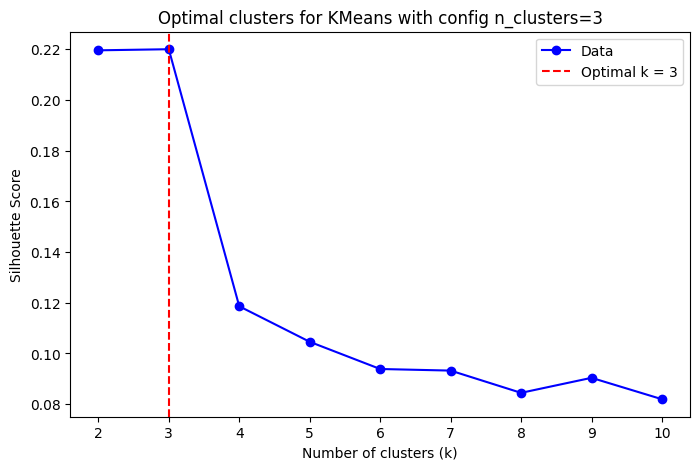

2025-02-26 17:28:14: INFO - Optimum number of clusters for 'authority' with 'KMeans': 3 using configuration: {'n_clusters': 3}
2025-02-26 17:28:14: INFO - Evaluating algorithm 2 of 8: 'GaussianMixture'
2025-02-26 17:28:14: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 2}
2025-02-26 17:28:15: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 3}
2025-02-26 17:28:15: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 4}
2025-02-26 17:28:16: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 5}
2025-02-26 17:28:18: INFO - Testing algorithm '<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>' with parameters: {'n_components': 6}
2025-02-26 17:28:19: INFO - Testing algorithm '<class 'sklearn.mixture._g

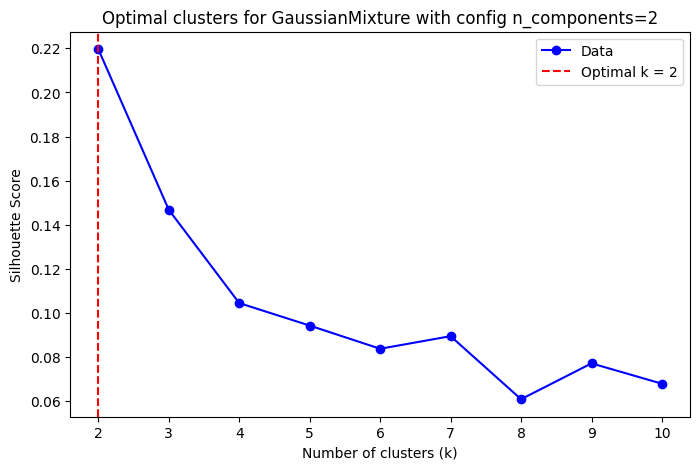

2025-02-26 17:28:27: INFO - Optimum number of clusters for 'authority' with 'GaussianMixture': 2 using configuration: {'n_components': 2}
2025-02-26 17:28:27: INFO - Evaluating algorithm 3 of 8: 'SpectralClustering'
2025-02-26 17:28:27: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'>' with parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors'}
2025-02-26 17:28:27: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'>' with parameters: {'n_clusters': 3, 'affinity': 'nearest_neighbors'}
2025-02-26 17:28:27: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'>' with parameters: {'n_clusters': 4, 'affinity': 'nearest_neighbors'}
2025-02-26 17:28:27: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'>' with parameters: {'n_clusters': 5, 'affinity': 'nearest_neighbors'}
2025-02-26 17:28:27: INFO - Testing algorithm '<class 'sklearn.cluster._spectral.SpectralClustering'

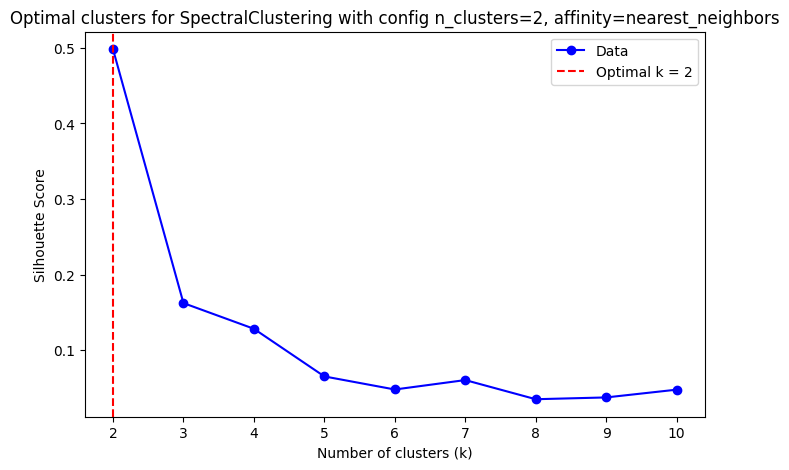

2025-02-26 17:28:29: INFO - Optimum number of clusters for 'authority' with 'SpectralClustering': 2 using configuration: {'n_clusters': 2, 'affinity': 'nearest_neighbors'}
2025-02-26 17:28:29: INFO - Evaluating algorithm 4 of 8: 'DBSCAN'
2025-02-26 17:28:29: INFO - Skipping 'DBSCAN' as it does not require finding the optimal number of clusters.
2025-02-26 17:28:29: INFO - Evaluating algorithm 5 of 8: 'OPTICS'
2025-02-26 17:28:29: INFO - Skipping 'OPTICS' as it does not require finding the optimal number of clusters.
2025-02-26 17:28:29: INFO - Evaluating algorithm 6 of 8: 'HDBSCAN'
2025-02-26 17:28:29: INFO - Skipping 'HDBSCAN' as it does not require finding the optimal number of clusters.
2025-02-26 17:28:29: INFO - Evaluating algorithm 7 of 8: 'MeanShift'
2025-02-26 17:28:29: INFO - Skipping 'MeanShift' as it does not require finding the optimal number of clusters.
2025-02-26 17:28:29: INFO - Evaluating algorithm 8 of 8: 'AffinityPropagation'
2025-02-26 17:28:29: INFO - Skipping 'Aff

+--------------------+-----------+----------------------------------------------------+
|     Algorithm      | Optimal K |                     Parameters                     |
+--------------------+-----------+----------------------------------------------------+
|       KMeans       |     3     |                 {'n_clusters': 3}                  |
|  GaussianMixture   |     2     |                {'n_components': 2}                 |
| SpectralClustering |     2     | {'n_clusters': 2, 'affinity': 'nearest_neighbors'} |
+--------------------+-----------+----------------------------------------------------+


In [21]:
# Create the directories to store the results for the analysis of the current persuasion principle
principle_path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)

# Log the creation process for the folder to save results
logger.info(f"Creating folder '{principle_path}' for saving results of '{POP}'...")

# Check if the folder already exists, if not, create it
if (not os.path.exists(principle_path)):
    os.makedirs(principle_path)  # Create the necessary directories
    logger.info(f"Folder '{principle_path}' created successfully.")
else:
    logger.info(f"Folder '{principle_path}' already exists.")  # Log if the folder exists already

# Log the process of determining the optimum number of clusters
logger.info(f"Determining the optimum number of clusters for '{POP}'")

# Initialize a dictionary to store the optimal number of clusters for each algorithm
optimal_clusters = {}

# Preprocess the data by scaling it (standardizing it)
raw_data = embed_df.drop(columns=["id", "path"]).values  # Drop non-relevant columns

X = None  # Initialize the scaled data variable
#Standardize the data using the StandardScaler if the directive for that was setted.
if (SCALE_DATA == True):
    logger.warning("Scaling the data using StandardScaler...")
    # Create a StandardScaler instance
    scaler = StandardScaler()  # Create a StandardScaler instance
    X = scaler.fit_transform(raw_data)  # Scale the data using the StandardScaler
else:
    logger.warning("Data will not be scaled.")
    X = raw_data

# Evaluate each clustering algorithm
total_algorithms = len(clustering_algorithms)  # Get the total number of algorithms to evaluate
for index, (algorithm_name, algorithm_info) in enumerate(clustering_algorithms.items(), start=1):
    
    # Log the current algorithm being evaluated
    logger.info(f"Evaluating algorithm {index} of {total_algorithms}: '{algorithm_name}'")
    
    try:
        # Only invoke 'find_optimal_k' if the algorithm requires determining the optimal number of clusters
        if algorithm_info['optimum_k']:
            optimal_k, best_params = find_optimal_k(
                X=X,  # Pass the scaled data
                algorithm_info=algorithm_info,  # Pass the algorithm-specific parameters
                export_path=principle_path  # Specify the path to save plots
            )

            if optimal_k is not None:
                # Save the optimal number of clusters and their parameters in the dictionary
                optimal_clusters[algorithm_name] = {
                    'optimal_k': optimal_k,
                    'params': best_params  # Save the optimal parameter configuration
                }

                # Log the best parameters and optimal number of clusters
                logger.info(
                    f"Optimum number of clusters for '{POP}' with '{algorithm_name}': {optimal_k} "
                    f"using configuration: {best_params}"  # Include the parameters in the log
                )
        else:
            logger.info(f"Skipping '{algorithm_name}' as it does not require finding the optimal number of clusters.")

    except Exception as error:
        # Log any error that occurs during the algorithm evaluation
        logger.error(f"Error processing '{algorithm_name}' for '{POP}': {error}")

# Log completion of the optimal number of clusters determination
logger.info("Optimum number of clusters completed!")

# Create a DataFrame from the optimal clusters dictionary
optimal_clusters_df = pd.DataFrame.from_dict(optimal_clusters, orient='index')

# If you want to display the DataFrame as a table, use PrettyTable for better visualization
# Create a PrettyTable object
table = PrettyTable()

# Define the columns of the table according to the DataFrame
table.field_names = ['Algorithm', 'Optimal K', 'Parameters']

# Fill the table with the values from the DataFrame
for algorithm, row in optimal_clusters_df.iterrows():
    table.add_row([algorithm, row['optimal_k'], row['params']])

# Print the final table with the algorithms and their optimal configurations
logger.info("Clustering algorithms and their parameters for optimal 'k' determination")
# Show the table in the console
print(table)

---
_**NOTE:** Although an automatic-analytical method for detecting the optimal number of groups is proposed here, it is up to the analyst to confirm or select a new optimal number of groups based on their expertise._

---

After the analytical method determines the optimal number of groups created, an interactive window is displayed for the analyst to confirm them.

In [22]:
optimal_clusters_df

,optimal_k,params
KMeans,3,{'n_clusters': 3}
GaussianMixture,2,{'n_components': 2}
SpectralClustering,2,"{'n_clusters': 2, 'affinity': 'nearest_neighbo..."


In [23]:
## Mostrar el DataFrame en una ventana interactiva
#gui = show(optimal_clusters_df)

## Después de hacer cambios en la GUI, obtén el DataFrame actualizado
#updated_data = gui.get_dataframes()["optimal_clusters_df"]  # Obtenemos el primer DataFrame modificado

## Mostrar el DataFrame actualizado
#print("Updated DataFrame:")
#updated_data = optimal_clusters_df

The optimal number of clusters confirmed by the analyst is displayed.

In [24]:
# Muestra el número óptimo de clusters para cada algoritmo y principio despuesde cerrar la GUI y haber confirmado (o actualizado) los valores 
# sugeridos por el metodo de detección del número óptimo de clusters.
updated_k = optimal_clusters_df
updated_k

,optimal_k,params
KMeans,3,{'n_clusters': 3}
GaussianMixture,2,{'n_components': 2}
SpectralClustering,2,"{'n_clusters': 2, 'affinity': 'nearest_neighbo..."


Once the optimal number of clusters has been determined, it should be updated in the configuration dictionary for the clustering algorithms (`clustering_algorithms`).


In [25]:
# Iterate over the clustering algorithms and their associated details
for algorithm, details in clustering_algorithms.items():
	# Check if the algorithm requires finding the optimal k and if it has a corresponding entry in updated_k
	if details['optimum_k'] and algorithm in updated_k.index:
		# Retrieve the parameters for the current algorithm from the DataFrame (using the algorithm as an index)
		params_from_df = updated_k.loc[algorithm, 'params']
		
		# Check for the existence of 'n_clusters', 'n_components', or 'n_partitions' in the DataFrame's parameters
		# and set the optimal k value accordingly.
		if 'n_clusters' in params_from_df:
			details['optimal_k'] = params_from_df['n_clusters']
		elif 'n_components' in params_from_df:
			details['optimal_k'] = params_from_df['n_components']
		elif 'n_partitions' in params_from_df:
			details['optimal_k'] = params_from_df['n_partitions']
		
		# Update the algorithm's parameters in the dictionary with the values from the DataFrame
		details['params'] = params_from_df

# Create a PrettyTable instance to display the results in a tabular format
table = PrettyTable()
# Define the headers of the table
table.field_names = ["Algorithm", "Search for k?", "optimal k", "params"]

# Fill the table with the updated information from the clustering_algorithms dictionary
for algorithm, details in clustering_algorithms.items():
	# Determine if the algorithm requires searching for the optimal k
	search_for_k = "Yes" if details['optimum_k'] else ""
	# Get the optimal k value if it exists, otherwise leave it blank
	optimal_k = details.get('optimal_k', '')
	# Retrieve the parameters for the algorithm
	params = details['params']
	
	# Add a new row to the table with the algorithm's information
	table.add_row([algorithm, search_for_k, optimal_k, params])

# Display the table in the console
print(table)

+---------------------+---------------+-----------+----------------------------------------------------------------+
|      Algorithm      | Search for k? | optimal k |                             params                             |
+---------------------+---------------+-----------+----------------------------------------------------------------+
|        KMeans       |      Yes      |     3     |                       {'n_clusters': 3}                        |
|   GaussianMixture   |      Yes      |     2     |                      {'n_components': 2}                       |
|  SpectralClustering |      Yes      |     2     |       {'n_clusters': 2, 'affinity': 'nearest_neighbors'}       |
|        DBSCAN       |               |           | {'eps': [0.1, 0.2, 0.3, 0.5, 1.0], 'min_samples': [5, 10, 15]} |
|        OPTICS       |               |           |  {'min_samples': [5, 10, 15, 20], 'max_eps': [1.0, 1.5, 2.0]}  |
|       HDBSCAN       |               |           |             

Save the configurations of the clustering algorithms for later analysis and reference.

In [26]:
# Ensure the result folder exists, if not raise an error
if not os.path.exists(RESULT_FOLDER):
	logger.error(f"Result folder '{RESULT_FOLDER}' not found.")  # Log an error if the folder doesn't exist
	raise FileNotFoundError(f"Result folder '{RESULT_FOLDER}' not found.")  # Raise an exception to halt further execution

# Build the file path for the pickle file
path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)  # Combine the result folder and principle folder
file_name = "clustering_algorithms_config.pkl"  # Define the name of the pickle file
file_path = os.path.join(path, file_name)  # Final file path

# Ensure the destination folder exists, if not, create it
if not os.path.exists(path):  # Check if the destination path exists
	logger.info(f"The destination folder '{path}' does not exist. Creating the folder...")  # Log info that the folder doesn't exist
	os.makedirs(path)  # Create the destination folder if it doesn't exist

# Validate that the clustering algorithms dictionary is not empty
if not clustering_algorithms:  # Check if the dictionary is empty
	logger.error("The 'clustering_algorithms' dictionary is empty. Cannot save the pickle file.")  # Log an error
	raise ValueError("The 'clustering_algorithms' dictionary is empty.")  # Raise an exception if the dictionary is empty

# Try saving the dictionary as a pickle file
try:
	# Open the file in write-binary mode and save the dictionary using pickle
	with open(file_path, 'wb') as pickle_file:
		pickle.dump(clustering_algorithms, pickle_file)  # Save the clustering algorithms dictionary to the file

	logger.info(f"Clustering algorithms and their configurations have been saved to '{file_path}' successfully!")  # Log success message
except Exception as e:
	logger.error(f"An error occurred while saving the pickle file: {e}")  # Log any error that occurs during the save operation
	raise  # Reraise the exception to halt execution


2025-02-26 17:28:29: INFO - Clustering algorithms and their configurations have been saved to 'results\authority\clustering_algorithms_config.pkl' successfully!


The optimal number of clusters is then stored in a CSV file as confirmed by the user. If the user wishes to use the optimal parameters, they can load and apply these values.

In [27]:
try:
	# Save the DataFrame to the CSV file
	output_path = os.path.join(path, "optimal_k_values.csv")  # Build the full output path for the CSV file
	logger.info(f"Saving the optimal number of clusters to `{output_path}`...")  # Log the process of saving the file

	updated_k.to_csv(output_path, index=False)  # Save the DataFrame 'updated_k' to a CSV file without row indices
	logger.info("File saved successfully.")  # Log a success message once the file is saved

# Catch NameError if the DataFrame is not defined
except NameError:
	logger.error("The `updated_data` DataFrame is not defined.")  # Log an error if the DataFrame is not found

# Catch any other exception that might occur
except Exception as e:
	logger.error(f"Error saving the file: {e}")  # Log any other exception error that may happen


2025-02-26 17:28:29: INFO - Saving the optimal number of clusters to `results\authority\optimal_k_values.csv`...
2025-02-26 17:28:29: INFO - File saved successfully.


## Clustering data using the optimum number of clusters

Now that the optimal number of clusters has been determined, the data is clustered using the pipeline, which evaluates all selected clustering algorithms with the previously identified optimal number of clusters. To begin, we'll review and confirm the algorithms to be applied and their respective configurations.

In [28]:
clustering_algorithms

{'KMeans': {'optimum_k': True,
  'class': sklearn.cluster._kmeans.KMeans,
  'params': {'n_clusters': 3},
  'optimal_k': 3},
 'GaussianMixture': {'optimum_k': True,
  'class': sklearn.mixture._gaussian_mixture.GaussianMixture,
  'params': {'n_components': 2},
  'optimal_k': 2},
 'SpectralClustering': {'optimum_k': True,
  'class': sklearn.cluster._spectral.SpectralClustering,
  'params': {'n_clusters': 2, 'affinity': 'nearest_neighbors'},
  'optimal_k': 2},
 'DBSCAN': {'optimum_k': False,
  'class': sklearn.cluster._dbscan.DBSCAN,
  'params': {'eps': [0.1, 0.2, 0.3, 0.5, 1.0], 'min_samples': [5, 10, 15]}},
 'OPTICS': {'optimum_k': False,
  'class': sklearn.cluster._optics.OPTICS,
  'params': {'min_samples': [5, 10, 15, 20], 'max_eps': [1.0, 1.5, 2.0]}},
 'HDBSCAN': {'optimum_k': False,
  'class': hdbscan.hdbscan_.HDBSCAN,
  'params': {'min_cluster_size': [5, 10, 15, 20]}},
 'MeanShift': {'optimum_k': False,
  'class': sklearn.cluster._mean_shift.MeanShift,
  'params': {}},
 'AffinityPro

To assess the performance of each algorithm in ``clustering_algorithms``, the Silhouette Score must be calculated based on the clustering results produced by each algorithm.  The `calculate_silhouette` function calculates the Silhouette Score, which is a metric used to evaluate the quality of clustering. The Silhouette Score ranges from -1 to +1, where a value closer to +1 indicates well-separated clusters, and a value closer to -1 indicates overlapping clusters.

In [29]:
# Function to calculate the Silhouette Score
def calculate_silhouette(X, labels):
	"""
	This function calculates the Silhouette Score, which is a metric used to evaluate the quality of clustering. 
	The Silhouette Score ranges from -1 to +1, where a value closer to +1 indicates well-separated clusters, 
	and a value closer to -1 indicates overlapping clusters.
	
	Parameters:
	X (array-like or pd.DataFrame): The data points to be clustered.
	labels (array-like): Cluster labels assigned to each data point.

	Returns:
	float: The Silhouette Score of the clustering result. If there is only one cluster (i.e., all data points have the same label), it returns -1.
	"""
	
	# Only calculate Silhouette Score if there is more than 1 cluster
	if len(np.unique(labels)) > 1:  # Silhouette only makes sense if there are more than one cluster
		return silhouette_score(X, labels)  # Calculate and return the Silhouette Score
	
	return -1  # Return -1 if there is only one cluster (i.e., no valid Silhouette Score can be computed)


Now, the data is grouped by considering all the clustering algorithms and their various configurations. The goal is to identify, for each algorithm, the configuration that yields the best Silhouette Score. This is based on the assumption that the clustering results with the highest Silhouette Score represent the most meaningful and well-separated groups. By doing this, we aim to ensure that the intensity of the persuasion principle being analyzed exhibits significant differences across the resulting clusters.

`get_clusters` checks whether the given clustering model has a `fit_predict` method. If it does, it uses it directly to obtain the cluster labels. Otherwise, it fits the model first and then retrieves the labels using either `labels_` or `predict()`.

In [30]:
def get_clusters(model, X_scaled):
	"""
	Fits a clustering model and returns the cluster assignments.

	This function checks whether the given clustering model has a `fit_predict` method.
	If it does, it uses it directly to obtain the cluster labels. Otherwise, it fits 
	the model first and then retrieves the labels using either `labels_` or `predict()`.

	Args:
		model (object): A clustering model instance (e.g., KMeans, DBSCAN, etc.).
		X_scaled (numpy.ndarray): The standardized dataset used for clustering.

	Returns:
		numpy.ndarray: An array containing the cluster labels assigned to each data point.
	"""
	if hasattr(model, 'fit_predict'):
		return model.fit_predict(X_scaled)  # Directly obtain cluster labels if supported
	
	model.fit(X_scaled)  # Fit the model if fit_predict() is not available

	# Retrieve cluster labels based on available attributes
	return model.labels_ if hasattr(model, 'labels_') else model.predict(X_scaled)


`calculate_centroids` checks if the given clustering model has built-in centroids (e.g., ``KMeans``, ``GaussianMixture``). If the model does not provide centroids directly, it manually calculates the mean of each cluster.

In [31]:
def calculate_centroids(model, clusters, X_scaled):
	"""
	Computes centroids for different clustering algorithms.

	This function checks if the given clustering model has built-in centroids 
	(e.g., KMeans, GaussianMixture). If the model does not provide centroids 
	directly, it manually calculates the mean of each cluster and ensures that 
	the result is always a 2D numpy array with shape (n_clusters, n_features).

	Args:
		model (object): A trained clustering model (e.g., KMeans, DBSCAN, etc.).
		clusters (numpy.ndarray): Array of cluster labels assigned to each data point.
		X_scaled (numpy.ndarray): Standardized dataset used for clustering.

	Returns:
		numpy.ndarray: A 2D numpy array with shape (n_clusters, n_features) representing 
						the centroids of each cluster.
	"""
	# If the model has predefined centroids (e.g., KMeans, GaussianMixture)
	if hasattr(model, "cluster_centers_"):
		return model.cluster_centers_

	# If the model is GaussianMixture, use the means_ attribute
	if hasattr(model, "means_"):
		return model.means_

	# If the model does not provide centroids, manually calculate them
	unique_clusters = set(clusters)
	
	# Calculate the mean vector for each cluster (excluding noise points, labeled as -1 in DBSCAN)
	centroids = np.array([X_scaled[clusters == cluster].mean(axis=0) 
						  for cluster in unique_clusters if cluster != -1])
	
	# Ensure that centroids are a 2D array (shape: n_clusters, n_features)
	return centroids

In [32]:
# Copiar el DataFrame original para almacenar los resultados del clustering
clustered_df = embed_df.copy()

# Preparar los datos de entrada (excluyendo las columnas 'id' y 'path')
X = embed_df.drop(columns=["id", "path"]).values  

X_scaled = None
# Aplicar StandardScaler para estandarizar los datos
if (SCALE_DATA == True):
    logger.warning("Scaling the data using StandardScaler...")
    X_scaled = StandardScaler().fit_transform(X)
else:
    logger.warning("Data will not be scaled")
    X_scaled = X

logger.info(f"Data shape for clustering: {X_scaled.shape}")

# Diccionario para almacenar los mejores resultados de cada algoritmo
clustering_results = {}

# Iterar sobre los algoritmos de clustering
for algo_name, algo_info in clustering_algorithms.items():
    logger.info(f"Starting clustering with algorithm: {algo_name}")

    algo_class = algo_info['class']
    algo_params = {k: v if isinstance(v, list) else [v] for k, v in algo_info['params'].items()}

    # Generar todas las combinaciones posibles de parámetros
    param_combinations = [dict(zip(algo_params.keys(), values)) for values in product(*algo_params.values())]
    logger.info(f"Generated {len(param_combinations)} parameter combinations for {algo_name}")

    # Variables para rastrear la mejor combinación para este algoritmo
    best_result = {'silhouette': -1, 'clusters': None, 'params': None, 'centroids': None, 'num_clusters': 0}

    # Iterar a través de las combinaciones de parámetros
    for i, params in enumerate(param_combinations, start=1):
        logger.info(f"Running {i} of {len(param_combinations)} for {algo_name} with params: {params}")

        try:
            model = algo_class(**params)
            logger.debug(f"Model initialized with params: {params}")  # Verifica los parámetros pasados

            # Obtener los clusters
            clusters = get_clusters(model, X_scaled)

            # Verificar si clusters es un vector válido
            if not isinstance(clusters, np.ndarray):
                raise ValueError(f"Clusters should be a numpy array. Got: {type(clusters)}")

            if clusters.ndim != 1:
                raise ValueError(f"Clusters should be a 1D array. Got: {clusters.ndim} dimensions")

            logger.debug(f"Clusters array: {clusters[:10]}")  # Muestra los primeros 10 valores de clusters para diagnóstico

            # Verificar si unique_clusters contiene valores válidos
            unique_clusters = set(clusters)
            logger.debug(f"Unique clusters: {unique_clusters}")  # Muestra los valores únicos de los clusters

            if len(unique_clusters) <= 1:
                logger.warning(f"Warning: Only one unique cluster found for {algo_name} with params: {params}")
                silhouette_avg = -1
            else:
                silhouette_avg = silhouette_score(X_scaled, clusters)
                logger.debug(f"Silhouette score for {algo_name} with params {params}: {silhouette_avg}")  # Muestra el valor del silhouette_score

            num_clusters = len(unique_clusters) if -1 not in unique_clusters else len(unique_clusters) - 1
            centroids = calculate_centroids(model, clusters, X_scaled)

            # Verificar si los centroides tienen la forma correcta
            logger.debug(f"Centroids: {centroids}")

            # Actualizar el mejor resultado si el nuevo score de silueta es mejor
            if silhouette_avg > best_result['silhouette']:
                best_result.update({
                    'silhouette': silhouette_avg,
                    'clusters': clusters,
                    'params': params,
                    'centroids': centroids,
                    'num_clusters': num_clusters
                })

        except Exception as e:
            logger.error(f"Error in {algo_name} with params {params}: {str(e)}")
            logger.debug(f"Traceback: {e.__traceback__}")  # Agregar el traceback completo del error para más detalles

    # Almacenar el mejor resultado para este algoritmo
    if best_result['clusters'] is not None:
        column_name = f"{algo_name} ({best_result['silhouette']:.4f})"
        clustered_df[column_name] = best_result['clusters']

        clustering_results[algo_name] = {
            'params': best_result['params'],
            'silhouette': best_result['silhouette'],
            'centroids': best_result['centroids'],
            'num_clusters': best_result['num_clusters']
        }

        logger.info(f"Best clustering for {algo_name} stored with silhouette score {best_result['silhouette']:.4f}.")

# Mostrar el DataFrame resultante con las mejores asignaciones de cluster
logger.info("Displaying the resulting DataFrame with the best cluster assignments.")
clustered_df

2025-02-26 17:28:29: WARNING - Scaling the data using StandardScaler...
2025-02-26 17:28:29: INFO - Data shape for clustering: (598, 768)
2025-02-26 17:28:29: INFO - Starting clustering with algorithm: KMeans
2025-02-26 17:28:29: INFO - Generated 1 parameter combinations for KMeans
2025-02-26 17:28:29: INFO - Running 1 of 1 for KMeans with params: {'n_clusters': 3}
2025-02-26 17:28:29: INFO - Best clustering for KMeans stored with silhouette score 0.1468.
2025-02-26 17:28:29: INFO - Starting clustering with algorithm: GaussianMixture
2025-02-26 17:28:29: INFO - Generated 1 parameter combinations for GaussianMixture
2025-02-26 17:28:29: INFO - Running 1 of 1 for GaussianMixture with params: {'n_components': 2}
2025-02-26 17:28:30: INFO - Best clustering for GaussianMixture stored with silhouette score 0.2230.
2025-02-26 17:28:30: INFO - Starting clustering with algorithm: SpectralClustering
2025-02-26 17:28:30: INFO - Generated 1 parameter combinations for SpectralClustering
2025-02-26 

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,id,path,KMeans (0.1468),GaussianMixture (0.2230),SpectralClustering (0.4982),DBSCAN (-0.0569),OPTICS (-0.0569),HDBSCAN (0.4293),MeanShift (0.2096),AffinityPropagation (0.0968)
0,0.096209,0.152683,0.193249,0.016189,0.375132,-0.261907,0.125467,0.432013,-0.001726,-0.183225,...,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,1,0,-1,-1,0,0,12
1,-0.072205,0.067802,0.357244,0.037719,0.436252,-0.128882,0.049326,0.316047,-0.004852,-0.207884,...,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,1,0,-1,-1,0,0,12
2,0.065490,0.073135,0.303711,-0.038981,0.392661,-0.142789,0.082904,0.269112,0.076318,-0.158853,...,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,-1,-1,0,0,16
3,0.126272,0.011344,0.367267,0.083592,0.449823,-0.145410,0.080765,0.221521,0.057800,-0.145011,...,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,13
4,0.184803,-0.030021,0.378522,0.010510,0.349926,-0.026439,0.058939,0.317805,0.040234,-0.133832,...,9767,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.150477,0.185594,0.334257,-0.059043,0.180246,-0.075516,0.097333,0.352394,0.109118,-0.154295,...,5690,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,-1,-1,0,0,29
594,0.234969,-0.043283,0.306206,0.148112,0.331764,-0.168138,0.072470,0.326924,0.058873,-0.193668,...,5691,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,48
595,0.105826,0.124749,0.355753,0.108981,0.347318,-0.225326,0.203359,0.278280,0.142702,-0.296989,...,5693,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,29
596,0.052480,0.092560,0.231235,-0.095931,0.295719,-0.077306,0.086920,0.346897,0.087620,0.006324,...,5697,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,1,0,-1,-1,0,0,49


In `clustering_results`, all the clustering process results are stored, including the best-performing parameter combinations for each algorithm. This dictionary contains key details such as the selected parameters, the silhouette score achieved, the identified number of clusters, and the centroids (if applicable). It serves as a comprehensive summary, allowing for easy comparison and evaluation of different clustering approaches. Let's check `clustering_results`:

The `clustering_results` dictionary stores the clustering outcomes for each algorithm, including the clustering parameters, the corresponding **Silhouette Score**, centroids, and the number of clusters generated. Each entry in this dictionary represents the results of one clustering algorithm, and is structured as follows:

- **Key**: The name of the algorithm (e.g., `KMeans`, `GaussianMixture`, `SpectralClustering`, etc.).
	
- **Value**: A dictionary containing the following information for each algorithm:
	- `'params'`: The parameters used to configure the algorithm. This could include settings such as the number of clusters (`n_clusters`), components (`n_components`), or other algorithm-specific parameters like `affinity` in `SpectralClustering`.
	- `'silhouette_score'`: The **Silhouette Score** for the clustering result, which indicates how well-separated the clusters are. A higher score suggests better-defined clusters.
	- `'centroids'`: The centroids of the clusters formed by the algorithm. For algorithms like `KMeans` or `GaussianMixture`, these are numeric arrays representing the centers of the clusters. For algorithms like `SpectralClustering`, centroids are stored in a dictionary with cluster labels as keys, and each entry contains the corresponding centroid values (e.g., the center of each cluster in a multi-dimensional space).
	- `'num_clusters'`: The number of clusters that were formed by the algorithm.

The `clustering_results` dictionary serves as a comprehensive storage of clustering results for each algorithm, including:
- The parameters that were used to perform the clustering.
- The Silhouette Score, which allows for evaluating the quality of the clustering.
- The centroids that characterize the center of the clusters (depending on the algorithm).
- The number of clusters formed, which is important for understanding the granularity of the clustering.

The dictionary provides a way to track and compare the clustering results from different algorithms in a consistent and structured manner. It helps in identifying which algorithm and parameters produced the best clustering results, which can later be used for further analysis or rerunning the clustering with optimized settings.


In [33]:
clustering_results

{'KMeans': {'params': {'n_clusters': 3},
  'silhouette': np.float64(0.14680446770347963),
  'centroids': array([[ 0.33790928, -0.1503578 , -0.14204315, ...,  0.11854317,
          -0.21029445,  0.25796142],
         [-0.23518823,  0.2092338 ,  0.00726643, ...,  0.09996847,
           0.26786248, -0.21985359],
         [-3.35984451,  0.22900515,  2.52114639, ..., -3.38759558,
           0.62023117, -2.0769584 ]], shape=(3, 768)),
  'num_clusters': 3},
 'GaussianMixture': {'params': {'n_components': 2},
  'silhouette': np.float64(0.22302529949011637),
  'centroids': array([[ 0.2676265 , -0.03309668, -0.11375209, ...,  0.1471253 ,
          -0.1511907 ,  0.1521262 ],
         [-1.21423135,  0.15016086,  0.51609745, ..., -0.66751293,
           0.68595779, -0.69020221]], shape=(2, 768)),
  'num_clusters': 2},
 'SpectralClustering': {'params': {'n_clusters': 2,
   'affinity': 'nearest_neighbors'},
  'silhouette': np.float64(0.4982082728553578),
  'centroids': array([[ 0.11025397, -0.0075148

It is now essential to save the results of the clustering process. These results are stored in the ``clustering_results`` dictionary, which is then saved as a pickle file for future use.

In [34]:
try:
	# Create the full path for the directory where the clustering results will be saved
	path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
	
	# Check if the folder exists; if it doesn't, create it
	if not os.path.exists(path):
		os.makedirs(path)  # This will create all the necessary directories

	# Create the file name for the pickle file
	file_name = f"clustering_results_{POP}.pkl"
	file_path = os.path.join(path, file_name)
	
	# Save the clustering results as a pickle file
	with open(file_path, 'wb') as f:
		pickle.dump(clustering_results, f)
	
	logger.info(f"Clustering results have been saved to '{file_path}' successfully!")

except Exception as e:
	# Log an error message if something goes wrong during the saving process
	logger.error(f"Failed to save clustering results to '{file_path}': {e}")

2025-02-26 17:29:02: INFO - Clustering results have been saved to 'results\authority\clustering_results_authority.pkl' successfully!


Now, the data with clusters assigned by each clustering algorithm is saved.

In [35]:
# Configurar el logger
logger = logging.getLogger(__name__)

try:
    # Crear la ruta completa donde se guardarán los resultados
    path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
    
    # Crear el directorio si no existe
    os.makedirs(path, exist_ok=True)  # Más eficiente que os.path.exists()

    # Crear el nombre y la ruta del archivo
    file_name = f"clustering_results_{POP}.csv"
    file_path = os.path.join(path, file_name)

    # Verificar si clustered_df es un DataFrame válido antes de guardarlo
    if isinstance(clustered_df, pd.DataFrame) and not clustered_df.empty:
        clustered_df.to_csv(file_path, index=False)
        logger.info(f"Clustering results have been saved to '{file_path}' successfully!")
    else:
        logger.warning("The clustering results DataFrame is empty or invalid. Skipping save.")

except Exception as e:
    logger.error(f"Failed to save clustering results: {e}")

At this stage, the data with clusters assigned should be saved. Up to this point, an ensemble clustering process has been carried out, where the data is grouped according to various algorithms.

In [36]:
try:
	# Create the full path for the directory where the data with clusters will be saved
	path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
	
	# Check if the folder exists; if it doesn't, create it
	if not os.path.exists(path):
		os.makedirs(path)  # This will create all the necessary directories

	# Create the file name for the embeddings CSV
	file_name = f"data_clustered_{POP}.csv"
	file_path = os.path.join(path, file_name)
	
	# Save the embeddings DataFrame as a CSV file
	clustered_df.to_csv(file_path, index=False, sep=",", decimal=".")
	logger.info(f"Data clustered considering '{POP}' have been saved to '{file_path}' successfully!")

except Exception as e:
	# Log an error message if something goes wrong during the saving process
	logger.error(f"Error saving Data clustered considering '{POP}' to '{file_path}': {e}")

Once all parameter combinations have been evaluated, the results are displayed. To do so, several functions must be defined.

`get_num_clusters` returns the number of clusters detected by a clustering model. The method used to retrieve the number of clusters depends on the specific algorithm used for clustering.

In [37]:
def get_num_clusters(model):
	"""
	This function returns the number of clusters detected by a clustering model.
	The method used to retrieve the number of clusters depends on the specific 
	algorithm used for clustering.

	Parameters:
	- model: A fitted clustering model (e.g., GaussianMixture, KMeans, DBSCAN)

	Returns:
	- int or None: Returns the number of clusters if available, otherwise None
	"""
	
	# Check if the model is of type GaussianMixture
	# GaussianMixture stores the number of clusters in the 'n_components_' attribute
	if isinstance(model, GaussianMixture) and hasattr(model, 'n_components_'):
		# Return the number of components (clusters) from the GaussianMixture model
		return model.n_components_

	# Check if the model has the 'n_clusters_' attribute
	# This is common for clustering models like KMeans, where the number of clusters is directly accessible
	elif hasattr(model, 'n_clusters_'):
		# Return the number of clusters from models that have this attribute
		return model.n_clusters_

	# For models like DBSCAN, the number of clusters is not directly available.
	# Instead, the model provides 'labels_', which represent the cluster assignments.
	# We count the unique labels to get the number of clusters
	elif hasattr(model, 'labels_'):
		# Count the number of unique labels (clusters) assigned to the data points
		return len(np.unique(model.labels_))

	# If none of the above conditions are met, we return None
	# This indicates that the number of clusters could not be determined
	return None


`process_algorithm_results` processes the clustering algorithm results from a DataFrame, computes statistical measures (such as min, max, mean, std, var), and stores the results in a dictionary.

In [38]:
# Initialize a dictionary to store statistical summaries for each algorithm
algorithm_stats = {}

def process_algorithm_results(clustering_results):
	"""
	Processes the clustering algorithm results stored in the `clustering_results` dictionary, 
	computes statistical measures (min, max, mean, std, var for silhouette scores), 
	and stores the results in `algorithm_stats`.

	Parameters:
	- clustering_results: Dictionary where each algorithm stores its best clustering results with:
		- 'params': Parameters used for clustering.
		- 'silhouette_score': Silhouette score for the clustering result.
		- 'centroids': Cluster centroids (array for most algorithms, dictionary for SpectralClustering).
		- 'num_clusters': The number of clusters formed.

	Updates the global dictionary `algorithm_stats` with statistics for each algorithm.
	"""

	# Iterate through each algorithm's results in the dictionary
	for algo_name, result in clustering_results.items():
		if not result:  # Skip if no results exist for the algorithm
			continue

		# Extract silhouette score and store as an array for statistical calculations
		silhouette_score = result['silhouette']

		# Compute statistics for the silhouette scores (assuming you might have more than one score)
		silhouette_scores = np.array(silhouette_score)  # If there are multiple scores, adjust accordingly
		
		# Store the computed statistics in the global dictionary
		algorithm_stats[algo_name] = {
			'silhouette': silhouette_score,  # Store the best silhouette score
			'params': result['params'],            # Store the parameters used
			'num_clusters': result['num_clusters'], # Store number of clusters formed
			'centroids': result['centroids'],      # Store centroids (array or dict)
			'max': np.max(silhouette_scores),      # Max score
			'min': np.min(silhouette_scores),      # Min score
			'mean': np.mean(silhouette_scores),    # Mean score
			'std': np.std(silhouette_scores),      # Standard deviation
			'var': np.var(silhouette_scores)       # Variance
		}

	return algorithm_stats  # Return the statistics dictionary if needed

`display_results` displays the computed algorithm statistics (e.g., min, max, mean, std, clusters) in a human-readable table format using PrettyTable. The function uses the global dictionary `algorithm_stats`, which contains statistical results for each algorithm, and formats them into a table

In [39]:
def display_results(clustering_results):
	"""
	Displays the best clustering results for each algorithm in a formatted table using PrettyTable.

	The function retrieves:
	- Algorithm name
	- Best silhouette score
	- Parameters used for the best clustering
	- Number of clusters formed
	- Centroids (not displayed in table but available in `clustering_results`)

	Parameters:
	- clustering_results: Dictionary storing the best clustering result per algorithm.
	
	The table is printed to the console for easy viewing.
	"""

	# Initialize PrettyTable
	table = PrettyTable()
	
	# Define table column headers
	table.field_names = [
		"Algorithm",       # Algorithm name
		"Silhouette Score",# Best silhouette score found
		"Parameters",      # Parameters used for the best clustering
		"Num Clusters"     # Number of clusters formed
	]

	# Iterate through each algorithm's results
	for algo_name, result in clustering_results.items():
		if not result:  # Skip empty results
			continue
		
		# Extract values
		silhouette_score = result.get('silhouette', 'N/A')
		params = result.get('params', 'N/A')
		num_clusters = result.get('num_clusters', 'N/A')

		# Add a row for each algorithm
		table.add_row([
			algo_name,
			f"{silhouette_score:.4f}" if isinstance(silhouette_score, (float, np.float64)) else silhouette_score,
			str(params),  # Convert parameters to string for readability
			num_clusters
		])
	
	# Print the table
	print(table)


`visualize_results` generates and displays a horizontal bar chart to visualize the Silhouette Scores of each clustering algorithm.

In [40]:
def visualize_results(clustering_results, SILHOUETTE_THRESHOLD=None):
	"""
	Generates and displays a horizontal bar chart to visualize the Silhouette Scores 
	of each clustering algorithm.

	The function creates a plot with:
	- Horizontal bars representing the best Silhouette score for each algorithm.
	- A vertical dashed line at the mean Silhouette score.
	- Error bars showing the standard deviation (if multiple scores exist).
	- An optional vertical dashed line at the provided SILHOUETTE_THRESHOLD.
	- Bolded labels for those bars that exceed the threshold.
	- Darker bars for those algorithms that exceed the threshold.

	Parameters:
	- clustering_results: Dictionary storing the best clustering result per algorithm.
	- SILHOUETTE_THRESHOLD: Optional threshold value to draw a vertical dashed line.
	"""
	
	# Check if there are results to visualize
	if not clustering_results:
		print("No clustering results to visualize.")
		return
	
	# Extract data for visualization
	algo_names = list(clustering_results.keys())
	silhouette_scores = []
	stats = []
	
	for algo_name in algo_names:
		result = clustering_results[algo_name]
		silhouette_scores.append(result.get('silhouette', np.nan))
		stats.append(result)  # Store the whole stats (e.g., max, min, etc.)

	# Create figure and axis
	fig, ax = plt.subplots(figsize=(10, 6))

	# Plot horizontal bars and statistics
	for i, (algo, score, stat) in enumerate(zip(algo_names, silhouette_scores, stats)):
		# Check if the silhouette score exceeds the threshold and highlight
		fontweight = 'bold' if SILHOUETTE_THRESHOLD is not None and score > SILHOUETTE_THRESHOLD else 'normal'
		bar_color = 'darkgray' if score > SILHOUETTE_THRESHOLD else 'lightgray'  # Darker gray for bars above threshold

		# Plot bar
		bar = ax.barh(algo, score, color=bar_color, alpha=0.7)

		# Annotate silhouette score value with bold if it exceeds the threshold
		ax.text(score + 0.01, i, f"{score:.4f}", va='center', fontsize=10, fontweight=fontweight)

		# Add error bars for standard deviation (bigotes)
		ax.errorbar(score, i, xerr=stat['std'], fmt='o', color='black', capsize=5, elinewidth=2)

		# Change the algorithm name on Y-axis to bold if score exceeds threshold
		ax.yaxis.get_ticklabels()[i].set_fontweight(fontweight)

	# If SILHOUETTE_THRESHOLD is provided, draw a vertical dashed line
	if SILHOUETTE_THRESHOLD is not None:
		ax.axvline(SILHOUETTE_THRESHOLD, color='red', linestyle='--', label=f'Threshold: {SILHOUETTE_THRESHOLD:.4f}')

		# Add a vertical line annotation with the threshold value
		ax.text(SILHOUETTE_THRESHOLD + 0.01, -0.5, f"Threshold: {SILHOUETTE_THRESHOLD:.4f}", 
				color='red', fontsize=10, verticalalignment='center', horizontalalignment='left')

	# Formatting the plot
	ax.set_xlabel("Silhouette Score")
	ax.set_ylabel("Algorithm")
	ax.set_title("Best Silhouette Scores by Clustering Algorithm")

	# If there's a threshold line, add a legend
	if SILHOUETTE_THRESHOLD is not None:
		ax.legend()

	# To avoid overlapping text and labels, use tight_layout and adjust subplots
	plt.tight_layout()
	
	# Show plot
	plt.show()


Now, the results of the clustering process is depicted.

In [41]:
# Execute the steps in sequence
clustering_results = process_algorithm_results(clustering_results)  # Process results to compute stats

logger.info("Clustering results statistics:")
display_results(clustering_results)  # Show the results in a table

+---------------------+------------------+----------------------------------------------------+--------------+
|      Algorithm      | Silhouette Score |                     Parameters                     | Num Clusters |
+---------------------+------------------+----------------------------------------------------+--------------+
|        KMeans       |      0.1468      |                 {'n_clusters': 3}                  |      3       |
|   GaussianMixture   |      0.2230      |                {'n_components': 2}                 |      2       |
|  SpectralClustering |      0.4982      | {'n_clusters': 2, 'affinity': 'nearest_neighbors'} |      2       |
|        DBSCAN       |     -0.0569      |           {'eps': 1.0, 'min_samples': 5}           |      1       |
|        OPTICS       |     -0.0569      |         {'min_samples': 5, 'max_eps': 1.0}         |      1       |
|       HDBSCAN       |      0.4293      |              {'min_cluster_size': 5}               |      2       |
|

The results of the clustering algorithms are displayed in a graph, providing a visual representation of the performance and comparisons between the different algorithms.

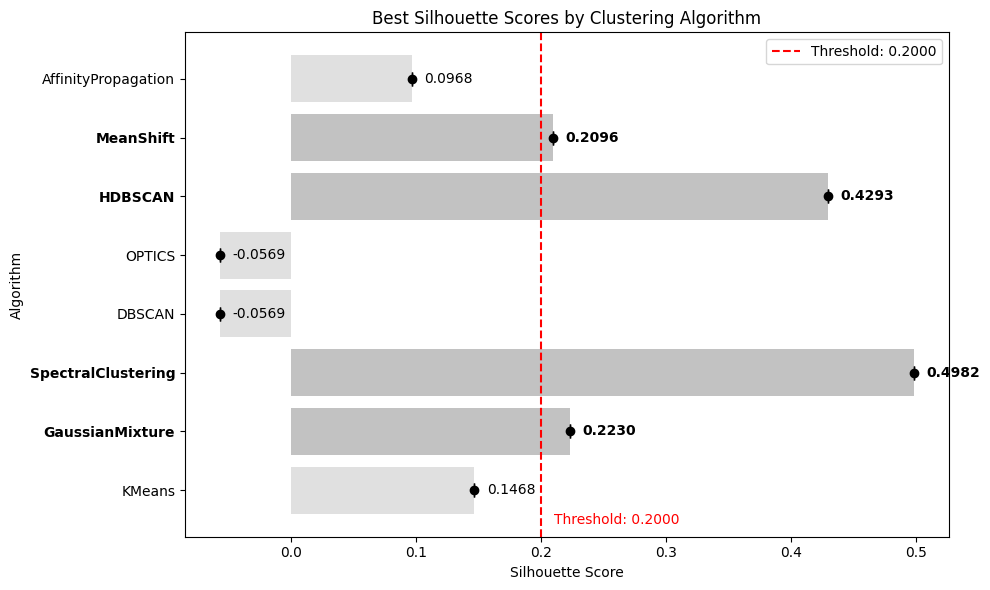

In [42]:
logger.info("Visualizing clustering results:")
visualize_results(clustering_results,  SILHOUETTE_THRESHOLD)  # Visualize the results

Before proceeding, it is important to check the value of the threshold set for the Silhouette Score, which is managed through the ``SILHOUETTE_THRESHOLD`` variable. This threshold is used to filter out any clustering algorithms that yield a Silhouette Score below the specified value. By doing this, only the algorithms that perform well according to the Silhouette Score will be retained for further analysis. This ensures that the final clusters are generated using the most effective and reliable algorithm configurations, improving the overall quality and interpretability of the clustering results.

In [43]:
# SILHOUETTE_THRESHOLD: Minimum Silhouette Score for considering clustering algorithms
# This threshold is applied to filter out algorithms whose Silhouette Score falls below the defined
# minimum acceptable value. By setting this threshold, only algorithms that produce well-defined clusters
# with high separation (indicated by a higher Silhouette Score) will be selected for the final clustering task.
# A higher threshold ensures that only the most reliable clustering results are retained, improving the 
# overall quality and consistency of the clustering process.

logger.info(f"Silhouette Score threshold for clustering assignment is set to {SILHOUETTE_THRESHOLD}.")

---

_**Note:** Data should be filtered to retain only the clustering results where the Silhouette Score exceeds the specified threshold. This ensures that only well-defined and high-quality clusters, as indicated by a Silhouette Score above the set limit, are considered for further analysis._

---


Once each clustering algorithm has assigned its respective groups to the data, these results must be stored with the generated labels. These labeled data from different clustering algorithms constitute what is known as **Clustering Ensemble**. The **Clustering Ensemble** is an approach that combines the results of multiple clustering algorithms with the goal of obtaining a global or final labeling that best captures the structure of the data.

The challenge now is to merge the labels generated by each algorithm into a single global labeling system. Several strategies exist to combine the results of different algorithms and generate a single set of labels. Some of the most common strategies include:

1. **Majority Voting**: In this strategy, each data point receives its final label based on the majority of labels assigned by the algorithms. If a point belongs to the same group in the majority of the algorithms, that label is assigned as the final label.

2. **Meta-clustering**: Instead of directly assigning a final label, this technique groups the labels from the different algorithms and then applies an additional clustering algorithm on these labels. This creates a "meta-label" that combines the decisions from the base algorithms.

3. **Co-association Matrix**: In this strategy, a matrix is computed showing the frequency with which two data points are grouped together in the same cluster by different algorithms. This matrix is then used to build a new clustering algorithm that assigns final labels to the data based on the co-association between the points.

4. **Cluster-based Similarity Partitioning (CSPA)**: This is an ensemble technique that combines the results of clustering algorithms using a similarity matrix. Each point is assigned a final label based on its similarity with other points across different algorithms.

---

**Comparison and Critical Analysis of Clustering Labeling Methods**

| **Method**                 | **Description**                                                                                                                                                              | **Advantages**                                                                                                                                                           | **Disadvantages**                                                                                                                                                    |
|----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Majority Voting**         | The final label is assigned based on the majority of labels from different algorithms.                                                                                         | Simple to implement, intuitive, and effective when algorithms have similar performance.                                                                                  | May not work well when algorithms have highly divergent results or when there is no clear majority.                                                                  |
| **Meta-clustering**         | A meta-clustering algorithm is applied to the labels from base algorithms, creating new clusters.                                                                            | Can account for diverse clustering outputs, improving the robustness of the final labels.                                                                                | May introduce complexity, and the meta-clustering algorithm itself could impact performance if not chosen carefully.                                                    |
| **Co-association Matrix**   | A matrix showing the frequency with which data points are grouped together by different algorithms is used to build final labels.                                               | Takes into account the relationships between points across multiple algorithms, making it more robust.                                                                  | Computationally expensive, especially with large datasets, and can be sensitive to the co-association matrix construction.                                                |
| **Cluster-based Similarity Partitioning (CSPA)** | Uses a similarity matrix based on the results of different algorithms to generate final labels.                                                                             | Robust, particularly when algorithms produce similar clustering structures.                                                                                                | Computationally intensive and may require tuning of similarity measures. Sensitive to noise in the initial clustering results.                                            |

From the former analysis it is found that:

- **Majority Voting** is a simple, efficient, and effective method when the clustering results are similar across algorithms. However, it may struggle with divergent clustering solutions.
- **Meta-clustering** is ideal when combining algorithms with different clustering behaviors, but it introduces complexity and requires careful tuning.
- **Co-association Matrix** is a powerful technique that can incorporate relationships between data points from different clustering outputs, but it can be slow with large datasets.
- **CSPA** offers a robust and flexible approach, but it is computationally expensive and sensitive to noise.

Each method has its strengths and weaknesses, and the best approach will depend on the specific use case and the clustering algorithms involved.

---

### **Ensemble clustering approach proposed**

At this stage, the dataset has been clustered using different algorithms defined in the `clustering_algorithms` dictionary. The results of each algorithm are stored in the `clustering_results` dictionary, which includes:

- The parameters used during clustering.
- The cluster assignments for each data point.
- The **Silhouette Score**, which evaluates clustering quality.
- The centroids of each cluster (when applicable).

From these results, two key challenges arise:

1. **Determining cluster correspondences across different clustering algorithms.**
2. **Developing an ensemble system that integrates the cluster assignments from all algorithms.**

#### **Cluster correspondence and autocorrespondence definition**  

Let $\mathcal{G}$ be the set of clustering algorithms, where each algorithm $g_i \in \mathcal{G}$ partitions the dataset $X$ into clusters. The clustering function is defined as:

$$
g_i: X \to C_i
$$

where $X$ is the dataset, and $C_i$ represents the partition generated by algorithm $g_i$:

$$
C_i = \{c_{i1}, c_{i2}, ..., c_{ik_i} \}
$$

with $k_i$ being the number of clusters found by $g_i$.

For two algorithms $g_i, g_j \in \mathcal{G}$, a cluster $c_{ix} \in C_i$ is said to **correspond** to a cluster $c_{jy} \in C_j$ if there exists a distance function $d$ such that:

$$
c_{ix} \sim c_{jy} \quad \text{if} \quad d(c_{ix}, c_{jy}) = \min_{c \in C_j} d(c_{ix}, c)
$$

That is, $c_{ix}$ from algorithm $g_i$ corresponds to $c_{jy}$ from algorithm $g_j$ if their distance is minimal among all possible cluster pairings in $C_j$.

The distance metric $d$ can be defined in several ways, such as:

- **Centroid Distance**: Euclidean or **_cosine_** distance between cluster centroids (for centroid-based algorithms).
- **Silhouette Similarity**: Comparison based on the average **Silhouette Score** of data points in each cluster.
- **Intersection-Based Measures**: Weighted intersection of data points between clusters.

This correspondence analysis is crucial for integrating multiple clustering results into an **ensemble clustering model**, ensuring optimal cluster assignments based on various clustering techniques.

##### **Cluster correspondence**

A **correspondence** between clusters $c_{i,x}$ and $c_{j,y}$, produced by different algorithms $g_i$ and $g_j$, is a mapping that maximizes a similarity measure $S$:

$$
\operatorname{correspondence}(c_{i,x}, c_{j,y}) \iff S(c_{i,x}, c_{j,y}) = \max_{c \in C_j} S(c_{i,x}, c)
$$

where $S$ is a similarity function, such as Jaccard similarity, adjusted Rand index, or an information-theoretic metric.


##### **Cluster autocorrespondence** 

The **autocorrespondence** of a clustering algorithm $g_i$ evaluates the internal consistency of its clusters. A cluster $c_{i,x}$ is in autocorrespondence with itself if:

$$
\operatorname{autocorrespondence}(c_{i,x}) = S(c_{i,x}, c_{i,x}) = 1
$$

where $S(c_{i,x}, c_{i,x})$ represents a perfect similarity measure, indicating that the cluster is identical to itself.

More generally, for a given threshold $\tau$, two clusters within the same algorithm are considered in autocorrespondence if:

$$
\operatorname{autocorrespondence}(c_{i,x}, c_{i,y}) \iff S(c_{i,x}, c_{i,y}) \geq \tau
$$

where $\tau$ is a predefined threshold that determines if two clusters from the same algorithm are sufficiently similar.

##### **Objective of correspondence and autocorrespondence analysis**  

This analysis serves two main purposes:

1. **Identifying corresponding clusters across algorithms**: Establishing mappings between cluster assignments from different clustering methods.
2. **Evaluating internal consistency**: Measuring the stability and well-defined nature of clusters within each algorithm.

By leveraging these definitions, multiple clustering results can be integrated into a robust **ensemble clustering framework**.

---

First, the centroids are represented on a graph while maintaining their original proportions, allowing for a visual observation of their similarities and differences.

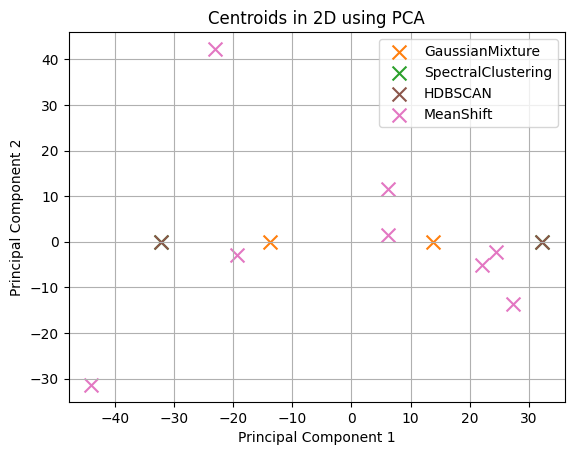

In [44]:
# Dimensionality reduction to 2D using PCA
pca = PCA(n_components=2)  # Set the number of principal components to 2 for 2D projection

# Dictionary to store the 2D positions of the centroids
centroids_2d = {}

# Extended color list (one unique color per algorithm)
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())  # Expanding the color list to avoid repetition
markers = ['x']  # All centroids will be represented with 'x' markers

# Iterate through the clustering results
for i, (alg_name, alg_data) in enumerate(clustering_results.items()):
	# Check if the Silhouette Score is greater than the threshold
	silhouette_score = alg_data['silhouette']
	num_clusters = alg_data['num_clusters']
	
	if (silhouette_score >= SILHOUETTE_THRESHOLD) and (num_clusters > 1):
		# Extract centroid data depending on the algorithm
		centroid_data = alg_data['centroids']
		
		# Handle the case where centroids are stored as a numpy array (e.g., KMeans, GaussianMixture)
		if isinstance(centroid_data, np.ndarray):
			# Ensure we have enough data for PCA (at least 2 centroids and 2 features)
			if centroid_data.shape[0] > 1 and centroid_data.shape[1] > 1:
				centroid_data_2d = pca.fit_transform(centroid_data)  # Apply PCA to reduce to 2D
			else:
				centroid_data_2d = centroid_data  # Skip PCA if not enough data
		# Handle the case where centroids are stored as a dictionary (e.g., SpectralClustering)
		elif isinstance(centroid_data, dict):
			centroid_data = list(centroid_data.values())  # Convert the dictionary values to a list of arrays
			# Ensure we have enough data for PCA
			if len(centroid_data) > 1 and centroid_data[0].shape[0] > 1:
				centroid_data_2d = pca.fit_transform(centroid_data)  # Apply PCA to reduce to 2D
			else:
				centroid_data_2d = np.array(centroid_data)  # Skip PCA if not enough data

		# Store the 2D centroids for later use
		centroids_2d[alg_name] = centroid_data_2d

		# Assign a unique color for each algorithm
		color = colors[i % len(colors)]  # Ensure colors do not repeat by cycling through the color list
		
		# Plot the 2D centroids with the algorithm's name as the label
		for j, (x, y) in enumerate(centroid_data_2d):
			plt.scatter(x, y,
						color=color,  # Assign the same color to all centroids of the same algorithm
						marker='x',   # Represent centroids with 'x' markers
						label=f"{alg_name}" if j == 0 else "", s=100)  # Only label the first centroid to avoid duplicate labels

# Customizing the plot
plt.title("Centroids in 2D using PCA")  # Set the title of the plot
plt.xlabel("Principal Component 1")  # Label the x-axis
plt.ylabel("Principal Component 2")  # Label the y-axis
plt.legend()  # Display the legend with algorithm names
plt.grid(True)  # Show grid lines for better readability

# Get the directory path where to save the plot
try:
	# Create the full path for the directory where the clustering results and plot will be saved
	path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
	
	# Check if the folder exists; if it doesn't, create it
	if not os.path.exists(path):
		os.makedirs(path)  # This will create all the necessary directories

	# Create the file name for the plot image
	plot_file_name = f"centroids_pca_{POP}.png"
	plot_file_path = os.path.join(path, plot_file_name)
	
	# Save the plot image
	plt.savefig(plot_file_path, dpi=300)  # Save the figure with high resolution
	logger.info(f"Centroid plot has been saved to '{plot_file_path}' successfully!")

except Exception as e:
	# Log an error message if something goes wrong during the saving process
	logger.error(f"Failed to save the centroid plot: {e}")

# Display the plot
plt.show()  # Render the plot to the screen


After clustering, it can happen that different algorithms return the same number of groups, but group 0 of algorithm 1 may not correspond to group 0 of algorithm 2; instead, it could correspond to group 7 (related as problem 1 stated before: 1. **Determining cluster correspondences across different clustering algorithms**). This becomes a problem for the future processes that will be developed. To address this issue, the idea is to identify similar groups by their centroids. The hypothesis is this: if group 0 of algorithm 1 has a centroid that is extremely close to the centroid of group 7 in algorithm 2, then they represent the same group, and both groups from each algorithm will be labeled as "Group A". There are several approaches to try to handle this:

| Approach                                   | **Advantages**                                          | **Disadvantages**                                      | **Best for**                                  |
|--------------------------------------------|---------------------------------------------------------|--------------------------------------------------------|-----------------------------------------------|
| **Centroid-based** (current proposed approach)           | Simple, fast, efficient for large data volumes          | Centroids are not always representative, sensitive to noise | Well-defined, convex groups                   |
| **Consensus Clustering**                   | Robust against inconsistencies, integrates information from multiple algorithms | Computationally expensive, hard to interpret         | Complex or non-convex data structures         |
| **Supervised Clustering with Labels**      | Accurate when there are known labels, flexible          | Depends on external information, requires training    | Labeled data or external information         |
| **Point-to-Point Similarity**              | Precise, robust to the shape of groups                  | Computationally expensive, issues with noise          | Complex or non-convex data                   |
| **Mixture Models (GMM)**                   | Flexible, probabilistic assignment                      | Assumptions about the data distribution are required   | Data with different distributions             |
| **Comparison Metrics (ARI, NMI)**          | Precise quantification of similarity between algorithms | Does not assign new labels, sensitive to parameters    | Quantitative evaluation of similarities       |

**Which is the Best Approach?**

- For well-defined data with convex groups, the centroid-based approach is likely the simplest and fastest.
- For complex or non-convex groups, consensus clustering or point-to-point similarity may be more robust.
- If you have prior labels or expert knowledge, supervised clustering could be the best option.
- For a quantitative evaluation of the similarity between algorithms, comparison metrics (such as ARI or NMI) are useful.

Finally, there is no "one-size-fits-all" best approach. The choice depends on the context and characteristics of the data.

---
**References:**

- Consensus Clustering: Monti, S., Tamayo, P., Mesirov, J., & Golub, T. (2003). Consensus clustering: A resampling-based method for class discovery and visualization of gene expression microarray data. *Machine Learning*, 52(1-2), 91-118. https://doi.org/10.1023/A:1023949509487

- Supervised Clustering with Labels: Google Developers. (n.d.). Supervised similarity measure. Retrieved from https://developers.google.com/machine-learning/clustering/dnn-clustering/overview?hl=en

- Point-to-Point Similarity: Google Developers. (n.d.). Embedding similarity measurement. Retrieved from https://developers.google.com/machine-learning/clustering/dnn-clustering/supervised-similarity?hl=en

- Mixture Models (GMM): McLachlan, G. J., & Peel, D. (2000). Finite Mixture Models. *Wiley-Interscience*.

- Comparison Metrics (ARI, NMI): Strehl, A., & Ghosh, J. (2002). Cluster ensembles—a knowledge reuse framework for combining multiple partitions. *Journal of Machine Learning Research*, 3, 583-617. https://www.jmlr.org/papers/volume3/strehl02a/strehl02a.pdf

---

### Problem 1: Determining cluster correspondences across different clustering algorithms

To address the first proposed problem, **"Determining cluster correspondences across different clustering algorithms"**, the hypothesis is as follows:

_In groups obtained by different clustering algorithms, regardless of the label assigned to each group, groups with centroids that are close to each other across different algorithms should be considered as the same group._

**Approach to Solve the Problem:**

1. **Identifying Centroids:**
	- Each clustering algorithm produces groups with centroids (the central points of each group). To compare groups from different algorithms, the focus will be on the centroids of these groups.

2. **Calculating Distances Between Centroids:**
	- The distance between centroids from groups obtained by different algorithms will be calculated. For text data, particularly phishing messages encoded using ``BERT`` embeddings, the representation of each message is transformed into a high-dimensional vector that captures its semantic meaning. In this case, **cosine similarity** is an ideal measure to assess the similarity between centroids across clustering algorithms.
	
	- **Why Cosine Similarity?**
	  - ``BERT`` embeddings represent the semantic content of text, focusing on the meaning rather than the exact wording. The **direction** of the embedding vector (which represents the text's meaning) is more important than the magnitude. Cosine similarity measures the cosine of the angle between two vectors, essentially quantifying how similar the direction of these vectors is, which aligns with how BERT encodes the semantic meaning of text.
	  
	  - Text embeddings, like those from ``BERT``, are high-dimensional (e.g., 768-dimensional vectors). In high-dimensional spaces, **Euclidean distance** can become less meaningful due to the **curse of dimensionality**. Cosine similarity, however, is less sensitive to the dimensionality and focuses on the angle between vectors, providing a more reliable measure of similarity in high-dimensional spaces.
	  
	  - Cosine similarity also normalizes the vectors, disregarding their magnitudes. This is crucial for comparing centroids from different groups, as it ensures that groups with similar meanings, even if they vary in scale, are treated as similar. Since ``BERT`` embeddings are designed to capture meaning, the magnitude of the vector isn't as relevant, and cosine similarity allows for a fair comparison between centroids that may differ in scale but have similar semantics.
	  
	  - Additionally, ``BERT`` embeddings capture contextual information, so two phishing messages with different words but similar meanings will have similar embeddings. Cosine similarity is ideal for this context, as it captures the similarity in meaning rather than the surface-level differences in the vocabulary.

	  - When clustering text data like phishing messages, different algorithms may produce varying labels and internal structures. Cosine similarity, by focusing on the orientation of centroids, enables a **robust comparison** of centroids and helps identify corresponding groups across algorithms, even when their original labels do not align.

3. **Defining a Similarity Threshold:**
	- To decide whether two centroids from groups of different algorithms represent the same group, a similarity threshold will be set based on the distance between the centroids. If the distance is smaller than the threshold, the groups will be considered equivalent.

4. **Labeling Corresponding Groups:**
	- Once similar centroids are identified, they will be assigned the same label or grouped under a common "supergroup." This step addresses the issue of different algorithms assigning different numbers of labels, even when the groups are conceptually similar.

5. **Evaluating Group Correspondence:**
	- Finally, we will evaluate whether the correspondence between groups from different algorithms is valid and appropriate, based on the proximity of the centroids.

**Benefits of This Approach:**

- **Reduction of Inconsistencies:** By matching groups based on the proximity of centroids, this approach reduces inconsistencies between the labels assigned by different algorithms.
- **Flexibility Across Algorithms:** It enables comparison and combination of groups from various algorithms, focusing solely on the similarity of centroids, without depending on the original labels.

**Possible Challenges:**

- **Threshold Selection:** Choosing an appropriate threshold is crucial. A threshold that is too low may lead to very few groups being considered equivalent, while a threshold that is too high might group dissimilar groups together. Selecting the right threshold is key to the success of this approach.

Cosine similarity is a widely used measure in text analysis and natural language processing, especially when vector representations such as those generated by models like ``BERT`` are employed. This measure evaluates the relative orientation of two vectors in a multidimensional space, without considering their magnitude. Mathematically, it is calculated as the cosine of the angle between the vectors, which helps determine how aligned they are in terms of direction.

In the context of ``BERT``, each text is represented as a vector in a high-dimensional space, where the proximity between vectors indicates semantic similarity. Cosine similarity is particularly well-suited to assess the similarity between these vectors, as it focuses on the direction of the vector and is insensitive to differences in magnitude. This means that even if two texts have different lengths or use different numbers of words, cosine similarity can still identify whether they share similar topics or meanings.

Furthermore, cosine similarity is robust to the "curse of dimensionality," a phenomenon that can affect other distance measures in high-dimensional spaces. This makes it a reliable tool for comparing centroids of text groups represented by ``BERT``, as it can identify meaningful semantic relationships between texts, regardless of their length or complexity.

Cosine similarity provides a precise and efficient evaluation of semantic similarity between texts represented by ``BERT``, facilitating the interpretation and analysis of text groups in natural language processing applications.

When analyzing the cosine similarity table between the centroids of the clusters, the following values are observed:

- High similarities (close to 1.0):

	- SpectralClustering_cluster0 and HDBSCAN_cluster0 have a similarity of 0.9883, indicating high semantic similarity between these two clusters.
	- SpectralClustering_cluster1 and HDBSCAN_cluster1 also show a similarity of 1.0, suggesting that these two clusters are virtually identical in terms of content.

- Moderate similarities (around 0.33):

	- The similarities between SpectralClustering_cluster0 and SpectralClustering_cluster1 (0.3333), as well as between HDBSCAN_cluster0 and HDBSCAN_cluster1 (0.3333), are relatively low, indicating that these clusters are semantically distinct from each other.

- Low similarities (around 0.33):

	- The similarities between SpectralClustering_cluster0 and HDBSCAN_cluster1 (0.3333), as well as between SpectralClustering_cluster1 and HDBSCAN_cluster0 (0.3347), are low, suggesting that these clusters do not share a high semantic similarity.

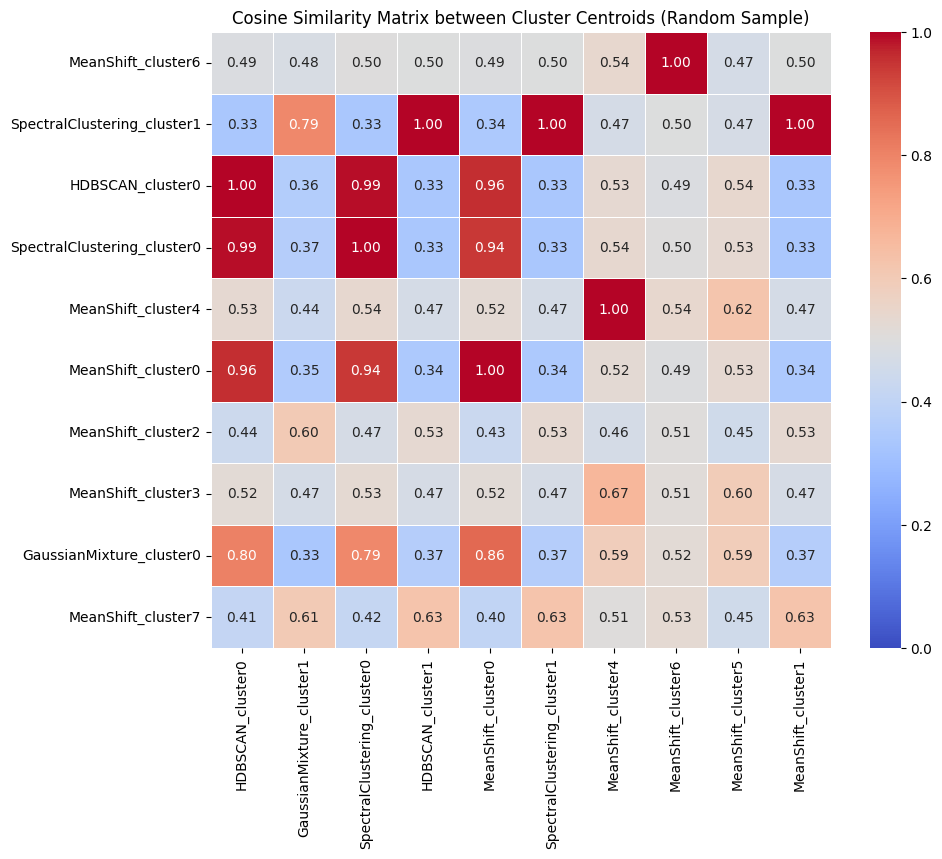

In [45]:
# Lists to store centroids and corresponding labels
centroid_list = []  # To store centroid vectors
labels = []  # To store corresponding labels for each centroid

# Loop through each clustering algorithm in the 'clustering_results' dictionary
for algo, result in clustering_results.items():
    # Extract silhouette score and check if it's above the threshold
    if result['silhouette'] > SILHOUETTE_THRESHOLD:
        centers = result['centroids']  # Extract centroids from the algorithm result
        if isinstance(centers, np.ndarray):  # Ensure centroids are a numpy array
            # Check if the number of clusters is greater than 1
            if len(centers) > 1:  # Filter out clustering results with only 1 cluster
                # Loop through each centroid and store it with the appropriate label
                centroid_list.extend(centers)  # Add all centroids to the list at once
                labels.extend([f"{algo}_cluster{i}" for i in range(len(centers))])  # Generate labels for each centroid
            else:
                logger.info(f"Clustering result for '{algo}' has only 1 cluster. Skipping.")
        else:
            logger.info(f"Centroids for '{algo}' are not in a valid format.")

# Check if any centroids passed the threshold and have more than 1 cluster
if not centroid_list:
    print("No centroids passed the silhouette threshold or have more than 1 cluster.")
else:
    # Convert the list of centroids to a numpy array for efficient computation
    centroid_array = np.array(centroid_list)

    # Calculate cosine distance between all pairs of centroids
    distances = cdist(centroid_array, centroid_array, metric='cosine')

    # Convert distance matrix into a similarity matrix: similarity = 1 / (1 + distance)
    similarity_matrix = 1 / (1 + distances)

    # Create a DataFrame for easier visualization and manipulation
    similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

    # Select a random sample of 10 rows and 10 columns for easier visualization
    row_sample = min(10, similarity_df.shape[0])
    col_sample = min(10, similarity_df.shape[1])
    sampled_similarity_df = similarity_df.sample(n=row_sample, axis=0).sample(n=col_sample, axis=1)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))  # Set the size of the figure
    sns.heatmap(sampled_similarity_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=0, vmax=1)

    # Title the heatmap for context
    plt.title('Cosine Similarity Matrix between Cluster Centroids (Random Sample)')

    # Try to save the plot
    try:
        # Construct the directory path and check if it exists
        path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
        os.makedirs(path, exist_ok=True)  # This creates the folder if it doesn't exist

        # Define the plot file name
        plot_file_name = f"cosine_similarity_{POP}.png"
        plot_file_path = os.path.join(path, plot_file_name)

        # Save the plot with high resolution
        plt.savefig(plot_file_path, dpi=300)
        logger.info(f"Cosine similarity image plot saved successfully at '{plot_file_path}'")

    except Exception as e:
        logger.error(f"Failed to save the centroid plot: {e}")

    # Display the plot
    plt.show()


The similarity matrix obtained should be saved for further analysis.

In [46]:
similarity_df

,GaussianMixture_cluster0,GaussianMixture_cluster1,SpectralClustering_cluster0,SpectralClustering_cluster1,HDBSCAN_cluster0,HDBSCAN_cluster1,MeanShift_cluster0,MeanShift_cluster1,MeanShift_cluster2,MeanShift_cluster3,MeanShift_cluster4,MeanShift_cluster5,MeanShift_cluster6,MeanShift_cluster7
GaussianMixture_cluster0,1.000000,0.333333,0.791406,0.365440,0.804933,0.365440,0.858115,0.365440,0.427150,0.540688,0.587372,0.590827,0.523311,0.425935
GaussianMixture_cluster1,0.333333,1.000000,0.365440,0.791406,0.362626,0.791406,0.352777,0.791406,0.602808,0.465007,0.435256,0.433378,0.478677,0.605244
SpectralClustering_cluster0,0.791406,0.365440,1.000000,0.333333,0.988300,0.333333,0.942107,0.333333,0.470016,0.531209,0.536236,0.533229,0.502727,0.416470
SpectralClustering_cluster1,0.365440,0.791406,0.333333,1.000000,0.334654,1.000000,0.340304,1.000000,0.534071,0.472254,0.468352,0.470669,0.497302,0.625443
HDBSCAN_cluster0,0.804933,0.362626,0.988300,0.334654,1.000000,0.334654,0.959677,0.334654,0.441351,0.520316,0.534543,0.541011,0.490597,0.412203
HDBSCAN_cluster1,0.365440,0.791406,0.333333,1.000000,0.334654,1.000000,0.340304,1.000000,0.534071,0.472254,0.468352,0.470669,0.497302,0.625443
MeanShift_cluster0,0.858115,0.352777,0.942107,0.340304,0.959677,0.340304,1.000000,0.340304,0.432051,0.516954,0.524421,0.532589,0.494743,0.404150
MeanShift_cluster1,0.365440,0.791406,0.333333,1.000000,0.334654,1.000000,0.340304,1.000000,0.534071,0.472254,0.468352,0.470669,0.497302,0.625443
MeanShift_cluster2,0.427150,0.602808,0.470016,0.534071,0.441351,0.534071,0.432051,0.534071,1.000000,0.491737,0.464958,0.450087,0.506247,0.557877
MeanShift_cluster3,0.540688,0.465007,0.531209,0.472254,0.520316,0.472254,0.516954,0.472254,0.491737,1.000000,0.669010,0.596516,0.514415,0.494682


In [47]:
# Get the directory path where to save the similarity results
try:
	# Create the full path for the directory where the clustering results and plot will be saved
	path = os.path.join(RESULT_FOLDER, PRINCIPLE_FOLDER)
	
	# Check if the folder exists; if it doesn't, create it
	if not os.path.exists(path):
		os.makedirs(path)  # This will create all the necessary directories

	# Create the file name for the similarity matrix CSV
	similarity_file_name = f"cosine_similarity_{POP}.csv"
	similarity_file_path = os.path.join(path, similarity_file_name)
	
	# Save the similarity matrix to a CSV file
	similarity_df.to_csv(similarity_file_path)  # Save the DataFrame as a CSV
	logger.info(f"Cosine similarity matrix has been saved to '{similarity_file_path}' successfully!")

except Exception as e:
	# Log an error message if something goes wrong during the saving process
	logger.error(f"Failed to save the cosine similarity matrix: {e}")

Now, the correspondence among clusters is calculated. To do so, `calculate_correspondence` calculates the correspondence between different clusters across different algorithms based on cosine similarity values. It compares the clusters of one algorithm with those of others, considering a dynamic threshold defined by the given percentile.

First, the valid and invalid algorithms, and the best algorithms concerning the Silhuoette score is determined.

In [48]:
clustering_results

{'KMeans': {'silhouette': np.float64(0.14680446770347963),
  'params': {'n_clusters': 3},
  'num_clusters': 3,
  'centroids': array([[ 0.33790928, -0.1503578 , -0.14204315, ...,  0.11854317,
          -0.21029445,  0.25796142],
         [-0.23518823,  0.2092338 ,  0.00726643, ...,  0.09996847,
           0.26786248, -0.21985359],
         [-3.35984451,  0.22900515,  2.52114639, ..., -3.38759558,
           0.62023117, -2.0769584 ]], shape=(3, 768)),
  'max': np.float64(0.14680446770347963),
  'min': np.float64(0.14680446770347963),
  'mean': np.float64(0.14680446770347963),
  'std': np.float64(0.0),
  'var': np.float64(0.0)},
 'GaussianMixture': {'silhouette': np.float64(0.22302529949011637),
  'params': {'n_components': 2},
  'num_clusters': 2,
  'centroids': array([[ 0.2676265 , -0.03309668, -0.11375209, ...,  0.1471253 ,
          -0.1511907 ,  0.1521262 ],
         [-1.21423135,  0.15016086,  0.51609745, ..., -0.66751293,
           0.68595779, -0.69020221]], shape=(2, 768)),
  'ma

In [49]:
# Filtrar algoritmos con num_clusters > 1 antes de buscar el mejor
valid_algorithms = {algo: result for algo, result in clustering_results.items() if result['num_clusters'] > 1}

# Obtener el mejor algoritmo basado en el silhouette_score y número de clusters
best_algorithm = max(
    valid_algorithms, 
    key=lambda x: (valid_algorithms[x]['silhouette'], valid_algorithms[x]['num_clusters']),
    default=None  # En caso de que todos tengan num_clusters <= 1, devuelve None
)

# Recuperar el silhouette_score y el número de clusters para el mejor algoritmo
if best_algorithm is not None:
    best_silhouette_score = clustering_results[best_algorithm]['silhouette']
    num_groups = clustering_results[best_algorithm]['num_clusters']
else:
    best_silhouette_score = None
    num_groups = None

# Identificar algoritmos que no superan el umbral de Silhouette y tienen más de un cluster
algorithms_below_threshold = {algo: clustering_results[algo]['silhouette'] for algo in valid_algorithms 
                              if clustering_results[algo]['silhouette'] < SILHOUETTE_THRESHOLD}

# Identificar algoritmos que superan el umbral de Silhouette y tienen más de un cluster
algorithms_above_threshold = {algo: clustering_results[algo]['silhouette'] for algo in valid_algorithms
                              if clustering_results[algo]['silhouette'] >= SILHOUETTE_THRESHOLD}

# Log de información sobre el mejor algoritmo
if best_algorithm:
    logger.info(f"The algorithm with the highest silhouette_score is: {best_algorithm} with a score of {best_silhouette_score:.4f} and {num_groups} clusters.")
else:
    logger.warning("No algorithm with num_clusters > 1 was found.")

# Log de algoritmos que no superan el umbral
if algorithms_below_threshold:
    logger.error(f"The following algorithms did not surpass the silhouette threshold ({SILHOUETTE_THRESHOLD}):")
    for algo, score in algorithms_below_threshold.items():
        num_clusters = clustering_results[algo]['num_clusters']
        logger.error(f"{algo}: {score:.4f}, with {num_clusters} clusters")
else:
    logger.info("All algorithms surpassed the silhouette threshold.")

# Log de algoritmos que superan el umbral
if algorithms_above_threshold:
    logger.info(f"The following algorithms surpassed the silhouette threshold ({SILHOUETTE_THRESHOLD}):")
    for algo, score in algorithms_above_threshold.items():
        num_clusters = clustering_results[algo]['num_clusters']
        logger.info(f"{algo}: {score:.4f}, with {num_clusters} clusters")
else:
    logger.info("No algorithms surpassed the silhouette threshold.")


The following algorithms did not surpass the silhouette threshold (0.2):
KMeans: 0.1468, with 3 clusters
AffinityPropagation: 0.0968, with 57 clusters


In [50]:
similarity_df

,GaussianMixture_cluster0,GaussianMixture_cluster1,SpectralClustering_cluster0,SpectralClustering_cluster1,HDBSCAN_cluster0,HDBSCAN_cluster1,MeanShift_cluster0,MeanShift_cluster1,MeanShift_cluster2,MeanShift_cluster3,MeanShift_cluster4,MeanShift_cluster5,MeanShift_cluster6,MeanShift_cluster7
GaussianMixture_cluster0,1.000000,0.333333,0.791406,0.365440,0.804933,0.365440,0.858115,0.365440,0.427150,0.540688,0.587372,0.590827,0.523311,0.425935
GaussianMixture_cluster1,0.333333,1.000000,0.365440,0.791406,0.362626,0.791406,0.352777,0.791406,0.602808,0.465007,0.435256,0.433378,0.478677,0.605244
SpectralClustering_cluster0,0.791406,0.365440,1.000000,0.333333,0.988300,0.333333,0.942107,0.333333,0.470016,0.531209,0.536236,0.533229,0.502727,0.416470
SpectralClustering_cluster1,0.365440,0.791406,0.333333,1.000000,0.334654,1.000000,0.340304,1.000000,0.534071,0.472254,0.468352,0.470669,0.497302,0.625443
HDBSCAN_cluster0,0.804933,0.362626,0.988300,0.334654,1.000000,0.334654,0.959677,0.334654,0.441351,0.520316,0.534543,0.541011,0.490597,0.412203
HDBSCAN_cluster1,0.365440,0.791406,0.333333,1.000000,0.334654,1.000000,0.340304,1.000000,0.534071,0.472254,0.468352,0.470669,0.497302,0.625443
MeanShift_cluster0,0.858115,0.352777,0.942107,0.340304,0.959677,0.340304,1.000000,0.340304,0.432051,0.516954,0.524421,0.532589,0.494743,0.404150
MeanShift_cluster1,0.365440,0.791406,0.333333,1.000000,0.334654,1.000000,0.340304,1.000000,0.534071,0.472254,0.468352,0.470669,0.497302,0.625443
MeanShift_cluster2,0.427150,0.602808,0.470016,0.534071,0.441351,0.534071,0.432051,0.534071,1.000000,0.491737,0.464958,0.450087,0.506247,0.557877
MeanShift_cluster3,0.540688,0.465007,0.531209,0.472254,0.520316,0.472254,0.516954,0.472254,0.491737,1.000000,0.669010,0.596516,0.514415,0.494682


In [51]:
def calculating_correspondence(similarity_df, target_algo, valid_algorithms, percentile=0.95):
    # Asegurar que el índice sea de tipo str
    similarity_df.index = similarity_df.index.astype(str)

    # Diccionario para almacenar las columnas que comienzan con cada algoritmo
    filtered_columns = {alg: [col for col in similarity_df.columns if col.startswith(alg)] for alg in valid_algorithms}

    # Filtrar filas cuyo índice comienza con target_algo
    algo_df = similarity_df[similarity_df.index.str.startswith(target_algo)]

    results = []

    for row in algo_df.index:
        for alg, cols in filtered_columns.items():
            if not cols:  # Evitar acceso a listas vacías
                continue
            
            algo_cols = algo_df.loc[row, cols]
            if algo_cols.empty:  # Evitar cálculos en Series vacías
                continue

            # Calcular el umbral del percentil especificado
            threshold = algo_cols.quantile(percentile)
            logger.info(f"Threshold for correspondence  for {cols} calculation: {threshold:.4f}")

            high_values = algo_cols[algo_cols >= threshold]

            for col, value in high_values.items():
                results.append((row, col, value))

    return pd.DataFrame(results, columns=['Current', 'Corresponding', 'Silhouette'])


In [52]:
valid_algorithms = []
for algo, score in algorithms_above_threshold.items():
	if (algo != best_algorithm):
		valid_algorithms.append(algo)        

valid_algorithms

['GaussianMixture', 'HDBSCAN', 'MeanShift']

The correspondence is calculated using `calculate_correspondence`.

In [53]:
best_algorithm

'SpectralClustering'

In [54]:
# Example usage of the function
correspondende_result_df = calculating_correspondence(similarity_df, best_algorithm, valid_algorithms, percentile=CORRESPONDENCE_THRESHOLD)  # Call the function with a DataFrame and percentile
correspondende_result_df

,Current,Corresponding,Silhouette
0,SpectralClustering_cluster0,GaussianMixture_cluster0,0.791406
1,SpectralClustering_cluster0,HDBSCAN_cluster0,0.988300
2,SpectralClustering_cluster0,MeanShift_cluster0,0.942107
3,SpectralClustering_cluster1,GaussianMixture_cluster1,0.791406
4,SpectralClustering_cluster1,HDBSCAN_cluster1,1.000000
5,SpectralClustering_cluster1,MeanShift_cluster1,1.000000


Once the correspondence is calculated, the clusters should be updated with their new correspondence values. The assignment of correspondences will be based on the algorithm that achieved the highest silhouette score.

In [55]:
clustered_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,id,path,KMeans (0.1468),GaussianMixture (0.2230),SpectralClustering (0.4982),DBSCAN (-0.0569),OPTICS (-0.0569),HDBSCAN (0.4293),MeanShift (0.2096),AffinityPropagation (0.0968)
0,0.096209,0.152683,0.193249,0.016189,0.375132,-0.261907,0.125467,0.432013,-0.001726,-0.183225,...,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,1,0,-1,-1,0,0,12
1,-0.072205,0.067802,0.357244,0.037719,0.436252,-0.128882,0.049326,0.316047,-0.004852,-0.207884,...,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,1,0,-1,-1,0,0,12
2,0.065490,0.073135,0.303711,-0.038981,0.392661,-0.142789,0.082904,0.269112,0.076318,-0.158853,...,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,-1,-1,0,0,16
3,0.126272,0.011344,0.367267,0.083592,0.449823,-0.145410,0.080765,0.221521,0.057800,-0.145011,...,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,13
4,0.184803,-0.030021,0.378522,0.010510,0.349926,-0.026439,0.058939,0.317805,0.040234,-0.133832,...,9767,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,0.150477,0.185594,0.334257,-0.059043,0.180246,-0.075516,0.097333,0.352394,0.109118,-0.154295,...,5690,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,-1,-1,0,0,29
594,0.234969,-0.043283,0.306206,0.148112,0.331764,-0.168138,0.072470,0.326924,0.058873,-0.193668,...,5691,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,48
595,0.105826,0.124749,0.355753,0.108981,0.347318,-0.225326,0.203359,0.278280,0.142702,-0.296989,...,5693,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,-1,-1,0,0,29
596,0.052480,0.092560,0.231235,-0.095931,0.295719,-0.077306,0.086920,0.346897,0.087620,0.006324,...,5697,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,1,0,-1,-1,0,0,49


In [56]:
cluster_mapping = {}

for _, row in correspondende_result_df.iterrows():
    algoritmo_origen, cluster_origen = row["Current"].split("_")
    algoritmo_destino, cluster_destino = row["Corresponding"].split("_")

    # Convertir los números de los clusters a enteros
    cluster_origen = int(cluster_origen.replace("cluster", ""))
    cluster_destino = int(cluster_destino.replace("cluster", ""))

    # Inicializar el diccionario si no existe
    if algoritmo_origen not in cluster_mapping:
        cluster_mapping[algoritmo_origen] = {}

    if cluster_origen not in cluster_mapping[algoritmo_origen]:
        cluster_mapping[algoritmo_origen][cluster_origen] = {}

    # Asignar el valor correspondiente
    cluster_mapping[algoritmo_origen][cluster_origen][algoritmo_destino] = cluster_destino

# Mostrar el resultado
import pprint
pprint.pprint(cluster_mapping)

{'SpectralClustering': {0: {'GaussianMixture': 0, 'HDBSCAN': 0, 'MeanShift': 0},
                        1: {'GaussianMixture': 1,
                            'HDBSCAN': 1,
                            'MeanShift': 1}}}


In [57]:
# Función para extraer el valor de silueta de una columna
def extract_silhouette_value(column_name):
    try:
        # Extraemos el valor de silueta entre paréntesis
        silhouette_value = float(column_name.split('(')[1].split(')')[0])
        return silhouette_value
    except IndexError:
        # Si el formato no es correcto, devuelve un valor por defecto (muy bajo para que se excluya)
        return -1

# Función para realizar el mapeo dinámico de clusters
def map_cluster_to_best_algorithm(base_algorithm, algorithm, cluster_value, cluster_mapping):
    """
    Mapea el valor del cluster de un algoritmo al valor del cluster del algoritmo base
    basándonos en el diccionario `cluster_mapping`.
    """
    # Buscar en el diccionario de mapeo para el algoritmo base
    for base_cluster, mappings in cluster_mapping[base_algorithm].items():
        # Si el valor de cluster en el algoritmo corresponde, devolver el valor de base_algorithm
        if mappings.get(algorithm) == cluster_value:
            return base_cluster
    return cluster_value  # Si no se encuentra, devuelve el valor original

# Extraer los nombres de los algoritmos del diccionario
algorithms_in_dict = clustering_algorithms.keys()

# Filtrar las columnas en 'df' que coinciden con los algoritmos en el diccionario
clustering_results_df = clustered_df[["id", "path"] + [col for col in clustered_df.columns if any(algo in col for algo in algorithms_in_dict)]]

# Filtrar columnas: mantener "id" y "path", y filtrar las columnas de algoritmos con silueta mayor al umbral
filtered_columns = [
    col for col in clustered_df.columns
    if (col == "id" or col == "path") or
       (any(algo in col for algo in algorithms_in_dict) and extract_silhouette_value(col) >= SILHOUETTE_THRESHOLD)
]

# Crear el DataFrame filtrado
filtered_df = clustered_df[filtered_columns]

# La variable base_algorithm (por ejemplo, "GaussianMixture") debe estar definida previamente
# Base algorithm (esto debe ser determinado dinámicamente, por ejemplo)
base_algorithm = best_algorithm  # Asumiendo que `best_algorithm` ya está definida en tu código

# Iterar sobre los algoritmos en el diccionario y mapear los clusters
for algo in algorithms_in_dict:
    # Filtrar las columnas correspondientes a este algoritmo
    algo_columns = [col for col in filtered_df.columns if algo in col]
    
    # Iterar sobre las columnas y aplicar el mapeo de clusters
    for col in algo_columns:
        filtered_df[col] = filtered_df[col].apply(lambda x: map_cluster_to_best_algorithm(base_algorithm, algo, x, cluster_mapping))

# Mostrar el DataFrame con los valores de clusters actualizados
filtered_df


C:\Users\lbust\AppData\Local\Temp\ipykernel_21648\3356548050.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].apply(lambda x: map_cluster_to_best_algorithm(base_algorithm, algo, x, cluster_mapping))


,id,path,GaussianMixture (0.2230),SpectralClustering (0.4982),HDBSCAN (0.4293),MeanShift (0.2096)
0,9762,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,0
1,9763,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,0
2,9764,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,0
3,9766,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,0
4,9767,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,0
...,...,...,...,...,...,...
593,5690,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,0
594,5691,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,0
595,5693,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,0,0,0,0
596,5697,/content/gdrive/MyDrive/Colabs/02.-Proyectos/P...,1,0,0,0


Vamos a revisar como quedaron los cambios luego del mapeo de correspondencias entre los grupos

In [58]:
# Crear un diccionario para almacenar los cambios realizados
mapping_changes = {}

# Iterar sobre los algoritmos en el diccionario
for algo in algorithms_in_dict:
    # Filtrar las columnas correspondientes a este algoritmo
    algo_columns = [col for col in filtered_df.columns if algo in col]
    
    # Iterar sobre las columnas de cada algoritmo
    for col in algo_columns:
        # Iterar sobre las filas del DataFrame para capturar los cambios
        for index, row in filtered_df.iterrows():
            original_value = clustered_df.loc[index, col]  # Valor original antes del mapeo
            mapped_value = row[col]  # Valor después del mapeo
            
            # Si hay un cambio, almacenarlo en el diccionario
            if original_value != mapped_value:
                # Si la clave (columna) no está en el diccionario, inicializamos una lista vacía
                if col not in mapping_changes:
                    mapping_changes[col] = []
                
                # Guardamos el cambio: (índice, valor original, valor mapeado)
                mapping_changes[col].append({
                    "index": index,
                    "original_value": original_value,
                    "mapped_value": mapped_value
                })

# Mostrar el diccionario con los cambios
print(mapping_changes)

{}


Now, it is necessary to determine the correspondence between the clusters of the algorithm that achieved the highest silhouette score and the clusters from the other algorithms. To do this, it is needed to use the ``clustering_results`` dictionary, where will look up the values corresponding to the algorithm with the highest silhouette score and establish the correspondence with the other algorithms.

Those algorithms that do not exceed the threshold value should be excluded from the correspondence table.

In [ ]:
# Filtrado de algoritmos sin repeticiones basados en el umbral de silueta
invalid_algos = [
	algo for algo, data in clustering_results.items()
	if data['silhouette'] < SILHOUETTE_THRESHOLD
]

invalid_algos

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Paso 1: Obtener todas las columnas que siguen el formato <algoritmo>_correspondiente
algos = [col for col in df_copy.columns if "_correspondiente" in col]
algos = [col.split(" ")[0].replace("_correspondiente", "") for col in algos]

algos_correspondientes = [algos + "_correspondiente" for algos in algos]

# Paso 2: Calcular el Adjusted Rand Score para cada par de columnas
for algo, algo_corresp in zip(algos, algos_correspondientes):
	# Obtener las etiquetas reales y las etiquetas correspondientes
	etiquetas_reales = df_copy[algo]
	etiquetas_correspondientes = df_copy[algo_corresp]

	# Calcular el Adjusted Rand Score
	ars = adjusted_rand_score(etiquetas_reales, etiquetas_correspondientes)
	print(f"Adjusted Rand Score para '{algo}' y '{algo_corresp}': {ars:.3f}")

	# Crear un nombre para la nueva columna con el ARS
	nueva_columna_con_ars = f"{algo} vs {algo_corresp} (ARS: {ars:.2f})"

	# Cambiar el nombre de la columna en el DataFrame
	df_copy.rename(columns={algo_corresp: nueva_columna_con_ars}, inplace=True)

	print(f"✅ Columna '{nueva_columna_con_ars}' actualizada con Adjusted Rand Score ({ars:.2f}).")
